In [ ]:
!pip install statannot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.family'] = 'helvetica'
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm
import matplotlib.colors as colors
import statannot
import scipy.stats as stats
import math

In [ ]:
#from matplotlib import font_manager
#font_manager. findSystemFonts()

In [ ]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A modified version of the add_stat_annotation from the package statannot is defined. The only modification is that it annotates p-values as "p-val = " rather than "p = ".

In [ ]:
from seaborn.utils import remove_na
from matplotlib import lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties

# Functions from .utils
def raise_expected_got(expected, for_, got, error_type=ValueError):
    """Raise a standardized error message.
    Raise an `error_type` error with the message
        Expected `expected` for `for_`; got `got` instead.
    Or, if `for_` is `None`,
        Expected `expected`; got `got` instead.
    """
    if for_ is not None:
        raise error_type(
            'Expected {} for {}; got {} instead.'.format(expected, for_, got)
        )
    else:
        raise error_type(
            'Expected {}; got {} instead.'.format(expected, got)
        )


def assert_is_in(x, valid_values, error_type=ValueError, label=None):
    """Raise an error if x is not in valid_values."""
    if x not in valid_values:
            raise_expected_got('one of {}'.format(valid_values), label, x)


# Function from .StatResult
class StatResult:
    def __init__(self, test_str, test_short_name, stat_str, stat, pval):
        self.test_str = test_str
        self.test_short_name = test_short_name
        self.stat_str = stat_str
        self.stat = stat
        self.pval = pval

    @property
    def formatted_output(self):
        if self.stat_str is None and self.stat is None:
            stat_summary = '{}, P_val:{:.3e}'.format(self.test_str, self.pval)
        else:
            stat_summary = '{}, P_val={:.3e} {}={:.3e}'.format(
                self.test_str, self.pval, self.stat_str, self.stat
            )
        return stat_summary

    def __str__(self):
        return self.formatted_output


# Statannot modification
DEFAULT = object()

def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p-val ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p-val = {}".format(pvalue_format).format(pval)

    return text + pval_text


def add_stat_annotation(ax, plot='boxplot',
                        data=None, x=None, y=None, hue=None, units=None, order=None,
                        hue_order=None, box_pairs=None, width=0.8,
                        perform_stat_test=True,
                        pvalues=None, test_short_name=None,
                        test=None, text_format='star', pvalue_format_string=DEFAULT,
                        text_annot_custom=None,
                        loc='inside', show_test_name=True,
                        pvalue_thresholds=DEFAULT, stats_params=dict(),
                        comparisons_correction='bonferroni',
                        use_fixed_offset=False, line_offset_to_box=None,
                        line_offset=None, line_height=0.02, text_offset=1,
                        color='0.2', linewidth=1.5,
                        fontsize='medium', verbose=1):
    """
    Optionally computes statistical test between pairs of data series, and add statistical annotation on top
    of the boxes/bars. The same exact arguments `data`, `x`, `y`, `hue`, `order`, `width`,
    `hue_order` (and `units`) as in the seaborn boxplot/barplot function must be passed to this function.
    This function works in one of the two following modes:
    a) `perform_stat_test` is True: statistical test as given by argument `test` is performed.
    b) `perform_stat_test` is False: no statistical test is performed, list of custom p-values `pvalues` are
       used for each pair of boxes. The `test_short_name` argument is then used as the name of the
       custom statistical test.
    :param plot: type of the plot, one of 'boxplot' or 'barplot'.
    :param line_height: in axes fraction coordinates
    :param text_offset: in points
    :param box_pairs: can be of either form: For non-grouped boxplot: `[(cat1, cat2), (cat3, cat4)]`. For boxplot grouped by hue: `[((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]`
    :param pvalue_format_string: defaults to `"{.3e}"`
    :param pvalue_thresholds: list of lists, or tuples. Default is: For "star" text_format: `[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]`. For "simple" text_format : `[[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]`
    :param pvalues: list or array of p-values for each box pair comparison.
    :param comparisons_correction: Method for multiple comparisons correction. `bonferroni` or None.
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hue_offset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hue_offset = box_plotter.hue_offsets[
                box_plotter.hue_names.index(hue)]

        group_pos = box_plotter.group_names.index(cat)
        box_pos = group_pos + hue_offset
        return box_pos

    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not
        direct access to the box_data in the BoxPlotter class.
        """
        cat = box_plotter.plot_hues is None and boxName or boxName[0]

        index = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[index]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = boxName[1]
            hue_mask = box_plotter.plot_hues[index] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]

    fig = plt.gcf()

    # Validate arguments
    if perform_stat_test:
        if test is None:
            raise ValueError("If `perform_stat_test` is True, `test` must be specified.")
        if pvalues is not None or test_short_name is not None:
            raise ValueError("If `perform_stat_test` is True, custom `pvalues` "
                             "or `test_short_name` must be `None`.")
        valid_list = ['t-test_ind', 't-test_welch', 't-test_paired',
                      'Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls',
                      'Levene', 'Wilcoxon', 'Kruskal']
        if test not in valid_list:
            raise ValueError("test value should be one of the following: {}."
                             .format(', '.join(valid_list)))
    else:
        if pvalues is None:
            raise ValueError("If `perform_stat_test` is False, custom `pvalues` must be specified.")
        if test is not None:
            raise ValueError("If `perform_stat_test` is False, `test` must be None.")
        if len(pvalues) != len(box_pairs):
            raise ValueError("`pvalues` should be of the same length as `box_pairs`.")

    if text_annot_custom is not None and len(text_annot_custom) != len(box_pairs):
        raise ValueError("`text_annot_custom` should be of same length as `box_pairs`.")

    assert_is_in(
        loc, ['inside', 'outside'], label='argument `loc`'
    )
    assert_is_in(
        text_format,
        ['full', 'simple', 'star'],
        label='argument `text_format`'
    )
    assert_is_in(
        comparisons_correction,
        ['bonferroni', None],
        label='argument `comparisons_correction`'
    )

    if verbose >= 1 and text_format == 'star':
        print("p-value annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if i < len(pvalue_thresholds)-1:
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1],
                                                        pvalue_thresholds[i+1][0],
                                                        pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        # 'outside', see valid_list
        else:
            line_offset = 0.03
            if line_offset_to_box is None:
                line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    if plot == 'boxplot':
        # Create the same plotter object as seaborn's boxplot
        box_plotter = sns.categorical._BoxPlotter(
            x, y, hue, data, order, hue_order, orient=None, width=width, color=None,
            palette=None, saturation=.75, dodge=True, fliersize=5, linewidth=None)
    elif plot == 'barplot':
        # Create the same plotter object as seaborn's barplot
        box_plotter = sns.categorical._BarPlotter(
            x, y, hue, data, order, hue_order,
            estimator=np.mean, ci=95, n_boot=1000, units=None,
            orient=None, color=None, palette=None, saturation=.75,
            errcolor=".26", errwidth=None, capsize=None, dodge=True)

    # Build the list of box data structures with the x and ymax positions
    group_names = box_plotter.group_names
    hue_names = box_plotter.hue_names
    if box_plotter.plot_hues is None:
        box_names = group_names
        labels = box_names
    else:
        box_names = [(group_name, hue_name) for group_name in group_names for hue_name in hue_names]
        labels = ['{}_{}'.format(group_name, hue_name) for (group_name, hue_name) in box_names]

    box_structs = [{'box':box_names[i],
                    'label':labels[i],
                    'x':find_x_position_box(box_plotter, box_names[i]),
                    'box_data':get_box_data(box_plotter, box_names[i]),
                    'ymax':np.amax(get_box_data(box_plotter, box_names[i])) if
                           len(get_box_data(box_plotter, box_names[i])) > 0 else np.nan}
                   for i in range(len(box_names))]
    # Sort the box data structures by position along the x axis
    box_structs = sorted(box_structs, key=lambda x: x['x'])
    # Add the index position in the list of boxes along the x axis
    box_structs = [dict(box_struct, xi=i) for i, box_struct in enumerate(box_structs)]
    # Same data structure list with access key by box name
    box_structs_dic = {box_struct['box']:box_struct for box_struct in box_structs}

    # Build the list of box data structure pairs
    box_struct_pairs = []
    for i_box_pair, (box1, box2) in enumerate(box_pairs):
        valid = box1 in box_names and box2 in box_names
        if not valid:
            raise ValueError("box_pairs contains an invalid box pair.")
            pass
        # i_box_pair will keep track of the original order of the box pairs.
        box_struct1 = dict(box_structs_dic[box1], i_box_pair=i_box_pair)
        box_struct2 = dict(box_structs_dic[box2], i_box_pair=i_box_pair)
        if box_struct1['x'] <= box_struct2['x']:
            pair = (box_struct1, box_struct2)
        else:
            pair = (box_struct2, box_struct1)
        box_struct_pairs.append(pair)

    # Draw first the annotations with the shortest between-boxes distance, in order to reduce
    # overlapping between annotations.
    box_struct_pairs = sorted(box_struct_pairs, key=lambda x: abs(x[1]['x'] - x[0]['x']))

    # Build array that contains the x and y_max position of the highest annotation or box data at
    # a given x position, and also keeps track of the number of stacked annotations.
    # This array will be updated when a new annotation is drawn.
    y_stack_arr = np.array([[box_struct['x'] for box_struct in box_structs],
                            [box_struct['ymax'] for box_struct in box_structs],
                            [0 for i in range(len(box_structs))]])
    if loc == 'outside':
        y_stack_arr[1, :] = ylim[1]
    ann_list = []
    test_result_list = []
    ymaxs = []
    y_stack = []

    for box_struct1, box_struct2 in box_struct_pairs:

        box1 = box_struct1['box']
        box2 = box_struct2['box']
        label1 = box_struct1['label']
        label2 = box_struct2['label']
        box_data1 = box_struct1['box_data']
        box_data2 = box_struct2['box_data']
        x1 = box_struct1['x']
        x2 = box_struct2['x']
        xi1 = box_struct1['xi']
        xi2 = box_struct2['xi']
        ymax1 = box_struct1['ymax']
        ymax2 = box_struct2['ymax']
        i_box_pair = box_struct1['i_box_pair']

        # Find y maximum for all the y_stacks *in between* the box1 and the box2
        i_ymax_in_range_x1_x2 = xi1 + np.nanargmax(y_stack_arr[1, np.where((x1 <= y_stack_arr[0, :]) &
                                                                           (y_stack_arr[0, :] <= x2))])
        ymax_in_range_x1_x2 = y_stack_arr[1, i_ymax_in_range_x1_x2]

        if perform_stat_test:
            result = statannot.stat_test(
                box_data1,
                box_data2,
                test,
                comparisons_correction,
                len(box_struct_pairs),
                **stats_params
            )
        else:
            test_short_name = test_short_name if test_short_name is not None else ''
            result = StatResult(
                'Custom statistical test',
                test_short_name,
                None,
                None,
                pvalues[i_box_pair]
            )

        result.box1 = box1
        result.box2 = box2
        test_result_list.append(result)

        if verbose >= 1:
            print("{} v.s. {}: {}".format(label1, label2, result.formatted_output))

        if text_annot_custom is not None:
            text = text_annot_custom[i_box_pair]
        else:
            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(result.test_short_name, result.pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = statannot.pval_annotation_text(result.pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(result.pval, simple_format_string, pvalue_thresholds, test_short_name)

        yref = ymax_in_range_x1_x2
        yref2 = yref

        # Choose the best offset depending on wether there is an annotation below
        # at the x position in the range [x1, x2] where the stack is the highest
        if y_stack_arr[2, i_ymax_in_range_x1_x2] == 0:
            # there is only a box below
            offset = y_offset_to_box
        else:
            # there is an annotation below
            offset = y_offset
        y = yref2 + offset
        h = line_height*yrange
        line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]
        if loc == 'inside':
            ax.plot(line_x, line_y, lw=linewidth, c=color)
        elif loc == 'outside':
            line = lines.Line2D(line_x, line_y, lw=linewidth, c=color, transform=ax.transData)
            line.set_clip_on(False)
            ax.add_line(line)

        # why should we change here the ylim if at the very end we set it to the correct range????
        # ax.set_ylim((ylim[0], 1.1*(y + h)))

        if text is not None:
            ann = ax.annotate(
                text, xy=(np.mean([x1, x2]), y + h),
                xytext=(0, text_offset), textcoords='offset points',
                xycoords='data', ha='center', va='bottom',
                fontsize=fontsize, clip_on=False, annotation_clip=False)
            ann_list.append(ann)

            plt.draw()
            y_top_annot = None
            got_mpl_error = False
            if not use_fixed_offset:
                try:
                    bbox = ann.get_window_extent()
                    bbox_data = bbox.transformed(ax.transData.inverted())
                    y_top_annot = bbox_data.ymax
                except RuntimeError:
                    got_mpl_error = True

            if use_fixed_offset or got_mpl_error:
                if verbose >= 1:
                    print("Warning: cannot get the text bounding box. Falling back to a fixed"
                          " y offset. Layout may be not optimal.")
                # We will apply a fixed offset in points,
                # based on the font size of the annotation.
                fontsize_points = FontProperties(size='medium').get_size_in_points()
                offset_trans = mtransforms.offset_copy(
                    ax.transData, fig=fig, x=0,
                    y=1.0*fontsize_points + text_offset, units='points')
                y_top_display = offset_trans.transform((0, y + h))
                y_top_annot = ax.transData.inverted().transform(y_top_display)[1]
        else:
            y_top_annot = y + h

        y_stack.append(y_top_annot)    # remark: y_stack is not really necessary if we have the stack_array
        ymaxs.append(max(y_stack))
        # Fill the highest y position of the annotation into the y_stack array
        # for all positions in the range x1 to x2
        y_stack_arr[1, (x1 <= y_stack_arr[0, :]) & (y_stack_arr[0, :] <= x2)] = y_top_annot
        # Increment the counter of annotations in the y_stack array
        y_stack_arr[2, xi1:xi2 + 1] = y_stack_arr[2, xi1:xi2 + 1] + 1

    y_stack_max = max(ymaxs)
    if loc == 'inside':
        ax.set_ylim((ylim[0], max(1.03*y_stack_max, ylim[1])))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

<>:366: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:368: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:366: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:368: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-829c6cd25893>:366: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
<ipython-input-5-829c6cd25893>:368: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':


## Expression fold-changes are imported and processed for the construction of the main figure

In [ ]:
# The log2 fold-changes and normalized differences previously obtained 
# (Data_preparation script) are imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/Figures_2021_06/Data_sim_ready/couples_divergence.csv')

In [ ]:
# Melted dataframe of log2 fold-changes and normalized differences are
# generated for the later construction of violin plots
# A new dataframe first needs to be made
log_original = couples_divergence[['Duplication', 'bm_fold_original', 
                                   'bp_fold_original']].copy()

log_original.columns = ['Duplication', 'Transcription rate',
                        'Translation rate']

data_log_original = log_original.melt(id_vars=['Duplication'],
                                      value_vars=['Transcription rate', 
                                                  'Translation rate'],
                                      var_name='Property',
                                      value_name='Log2 fold-change')

# Normalized differences with original data
diff_original = couples_divergence[['Duplication', 'bm_diff', 
                                   'bp_diff']].copy()

diff_original.columns = ['Duplication', 'Transcription rate',
                        'Translation rate']

data_diff_original = diff_original.melt(id_vars=['Duplication'],
                                        value_vars=['Transcription rate', 
                                                    'Translation rate'],
                                        var_name='Property',
                                        value_name='Normalized difference')

Before any figure is generated, medians of relative divergence are computed for the original dataset (as reported by Hausser et al.). The proportion of duplicate pairs where transcriptional divergence is greater than translational divergence is also assessed.

In [ ]:
# First, medians of relative divergence
med_bm_all = log_original['Transcription rate'].median()
med_bp_all = log_original['Translation rate'].median()

# For WGD
WGD_data = log_original[log_original['Duplication'] == 'WGD']
WGD_diff = diff_original[diff_original['Duplication'] == 'WGD']
med_bm_WGD = WGD_data['Transcription rate'].median()
med_bp_WGD = WGD_data['Translation rate'].median()

# For SSD
SSD_data = log_original[log_original['Duplication'] == 'SSD']
SSD_diff = diff_original[diff_original['Duplication'] == 'SSD']
med_bm_SSD = SSD_data['Transcription rate'].median()
med_bp_SSD = SSD_data['Translation rate'].median()

In [ ]:
# Comparisons of medians
ratio_all = 2**med_bm_all / 2**med_bp_all
ratio_WGD = 2**med_bm_WGD / 2**med_bp_WGD
ratio_SSD = 2**med_bm_SSD / 2**med_bp_SSD

print(f'ratio_all = {ratio_all}')
print(f'ratio_WGD = {ratio_WGD}')
print(f'ratio_SSD = {ratio_SSD}')

ratio_all = 1.4460442903314854
ratio_WGD = 1.4542615509142867
ratio_SSD = 1.4757488569227992


In [ ]:
# Second, proportion of couples where transcriptional divergence is of
# a larger magnitude

bm_larger_all = np.where(log_original['Transcription rate'] - log_original['Translation rate'] > 0, 1, 0)
prop_all = (bm_larger_all.sum() / log_original.shape[0]) * 100

# For WGD
bm_larger_WGD = np.where(WGD_data['Transcription rate'] - WGD_data['Translation rate'] > 0, 1, 0)
prop_WGD = (bm_larger_WGD.sum() / WGD_data.shape[0]) * 100

# For SSD
bm_larger_SSD = np.where(SSD_data['Transcription rate'] - SSD_data['Translation rate'] > 0, 1, 0)
prop_SSD = (bm_larger_SSD.sum() / SSD_data.shape[0]) * 100

print(f'prop_all = {prop_all}')
print(f'prop_WGD = {prop_WGD}')
print(f'prop_SSD = {prop_SSD}')

prop_all = 69.43765281173594
prop_WGD = 74.28571428571429
prop_SSD = 62.19512195121951


For subfigure B, a similar melted dataframe of log2 fold-changes is generated, but this time using recalculated transcription rates which account for the decay rates measured experimentally by Eser et al. (2014) for each transcript.

In [ ]:
log_Eser = couples_divergence[['Duplication', 'bm_fold_Eser', 
                                   'bp_fold_original']].copy()

log_Eser.columns = ['Duplication', 'Transcription rate', 'Translation rate']

data_log_Eser = log_Eser.melt(id_vars=['Duplication'],
                              value_vars=['Transcription rate', 
                                          'Translation rate'],
                              var_name='Property', 
                              value_name='Log2 fold-change')

For subfigure D of figure 1, signed Bm and Bp relative divergences are computed. For these signed fold-changes, the calculation is made in the two possible orientations for each paralog pair, and the correlation is computed on the resulting duplicated dataset.

In [ ]:
couples_divergence['Bm_signed_1'] = np.log2((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['Bp_signed_1'] = np.log2((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['pEst_signed_1'] = np.log2((10**couples_divergence['pEst_P1']) / (10**couples_divergence['pEst_P2']))

couples_divergence['Bm_signed_2'] = np.log2((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['Bp_signed_2'] = np.log2((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))
couples_divergence['pEst_signed_2'] = np.log2((10**couples_divergence['pEst_P2']) / (10**couples_divergence['pEst_P1']))

In [ ]:
# The duplicated datasets are assembled
Sign1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed_1', 
                            'Bp_signed_1', 'pEst_signed_1']]
Sign1.columns = ['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed', 
                            'Bp_signed', 'pEst_signed']

Sign2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed_2', 
                            'Bp_signed_2', 'pEst_signed_2']]
Sign2.columns = ['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed', 
                            'Bp_signed', 'pEst_signed']

Signed_all = pd.concat([Sign1, Sign2])

## Construction of Figure 1

In [ ]:
# To obtain the desired legend labels
rates_vars = {'Transcription rate': r"$\beta_m$", 
              'Translation rate': r"$\beta_p$"}

for row in range(data_log_original.shape[0]):
  data_log_original.at[row, 'Property'] = rates_vars[data_log_original.at[row, 'Property']]

for row in range(data_log_Eser.shape[0]):
  data_log_Eser.at[row, 'Property'] = rates_vars[data_log_Eser.at[row, 'Property']]

WGD_$\beta_m$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.775e-12 U_stat=4.102e+04
SSD_$\beta_m$ v.s. SSD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.685e-05 U_stat=1.732e+04
SSD_$\beta_p$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.250e-01 U_stat=2.261e+04
SSD_$\beta_m$ v.s. WGD_$\beta_m$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.052e+04
WGD_$\beta_m$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.262e-10 U_stat=4.028e+04
SSD_$\beta_m$ v.s. SSD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.104e-02 U_stat=1.544e+04
SSD_$\beta_p$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.250e-01 U_stat=2.261e+04
SSD_$\beta_m$ v.s. WGD_$\beta_m$: Mann-Whitney-Wilcoxon test two-sided with 

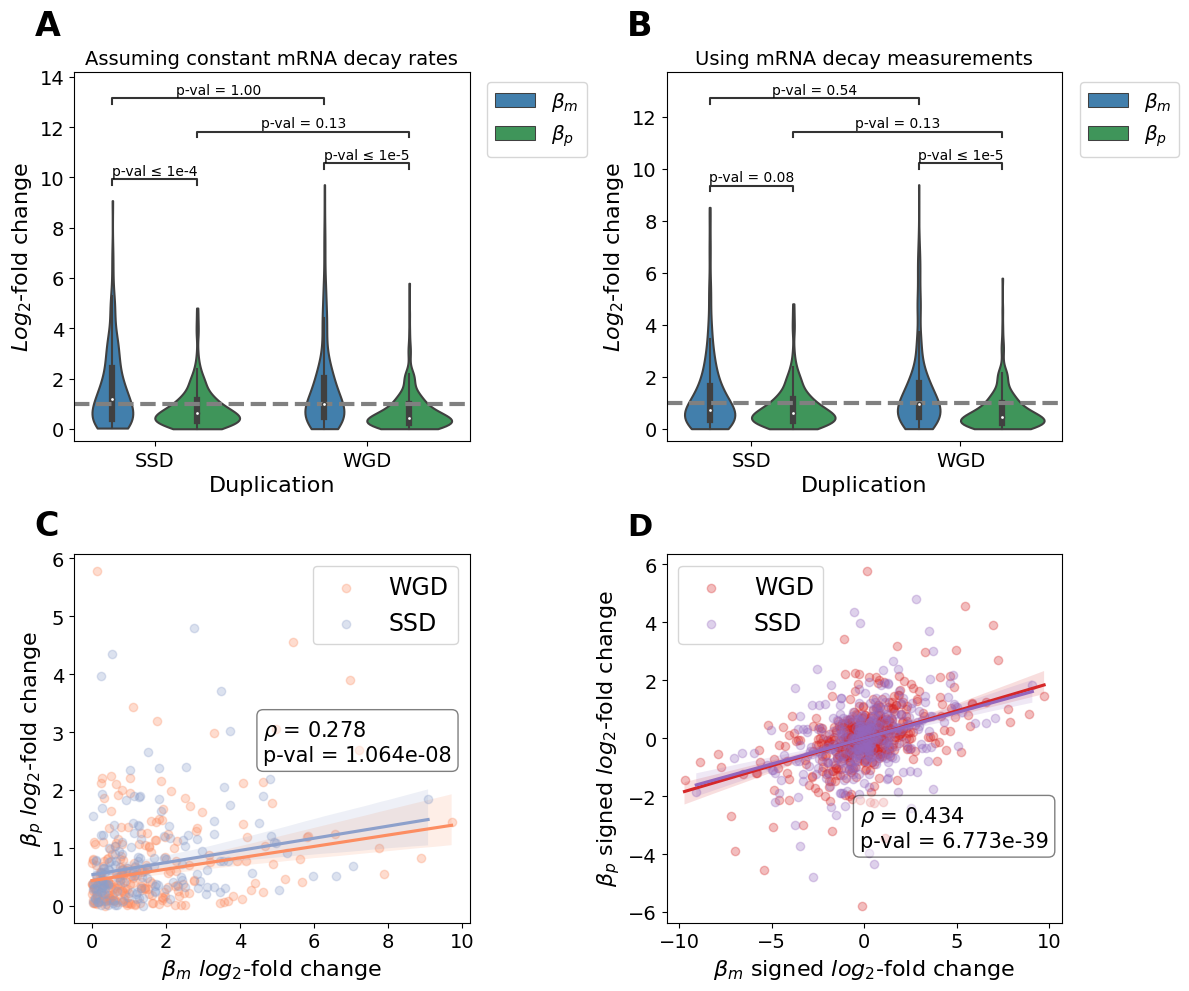

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Median to draw on both subfigures A and B
med_bm = log_original[log_original['Duplication'] == 'WGD']['Transcription rate'].median()

# Subfigure A
diff = sns.violinplot(x='Duplication', y='Log2 fold-change', hue='Property', 
                      data=data_log_original, ax=axs[0, 0], cut=0, 
                      palette={r"$\beta_m$": cm.tab20c.colors[0],
                               r"$\beta_p$": cm.tab20c.colors[8]})

diff.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

add_stat_annotation(diff, data=data_log_original, x='Duplication', 
                    y='Log2 fold-change', hue='Property', 
                    box_pairs=[(('WGD', r"$\beta_m$"), 
                                ('WGD', r"$\beta_p$")),
                               (('WGD', r"$\beta_p$"),
                                ('SSD', r"$\beta_p$")),
                               (('WGD', r"$\beta_m$"), 
                                ('SSD', r"$\beta_m$")),
                               (('SSD', r"$\beta_m$"),
                                ('SSD', r"$\beta_p$"))],
                    test='Mann-Whitney', text_format='simple', loc='inside')

axs[0, 0].axhline(y=med_bm, c='grey', linestyle='--', linewidth=3)

# Subfigure B
decay = sns.violinplot(x='Duplication', y='Log2 fold-change', hue='Property', 
                      data=data_log_Eser, ax=axs[0, 1], cut=0, 
                      palette={r"$\beta_m$": cm.tab20c.colors[0],
                               r"$\beta_p$": cm.tab20c.colors[8]})

decay.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

add_stat_annotation(decay, data=data_log_Eser, x='Duplication', 
                    y='Log2 fold-change', hue='Property', 
                    box_pairs=[(('WGD', r"$\beta_m$"), 
                                ('WGD', r"$\beta_p$")),
                               (('WGD', r"$\beta_p$"),
                                ('SSD', r"$\beta_p$")),
                               (('WGD', r"$\beta_m$"), 
                                ('SSD', r"$\beta_m$")),
                               (('SSD', r"$\beta_m$"),
                                ('SSD', r"$\beta_p$"))],
                    test='Mann-Whitney', text_format='simple', loc='inside')

axs[0, 1].axhline(y=med_bm, c='grey', linestyle='--', linewidth=3)

# Subfigure C
sns.regplot(x='Transcription rate', y='Translation rate', data=WGD_data, 
            ax=axs[1, 0], color=cm.Set2.colors[1], scatter_kws={'alpha':0.3}, 
            label='WGD', robust=True)

sns.regplot(x='Transcription rate', y='Translation rate', data=SSD_data, 
            ax=axs[1, 0], color=cm.Set2.colors[2], scatter_kws={'alpha':0.3}, 
            label='SSD', robust=True)

rho_div = stats.spearmanr(log_original['Transcription rate'], 
                          log_original['Translation rate'])

axs[1, 0].annotate(r"$\rho$ = "f'{round(rho_div[0], 3)}\np-val = {rho_div[1]:.3e}',
                (4.625, 2.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=15)

axs[1, 0].legend(fontsize=17)

# Subfigure D
sns.regplot(x='Bm_signed', y='Bp_signed', data=Signed_all[Signed_all['Duplication'] == 'WGD'], 
            ax=axs[1,1], color=cm.tab10.colors[3], scatter_kws={'alpha':0.3},
            label='WGD', robust=True)

sns.regplot(x='Bm_signed', y='Bp_signed', data=Signed_all[Signed_all['Duplication'] == 'SSD'], 
            ax=axs[1,1], color=cm.tab10.colors[4], scatter_kws={'alpha':0.3}, 
            label='SSD', robust=True)


rho_signed = stats.spearmanr(Signed_all['Bm_signed'], 
                             Signed_all['Bp_signed'])

axs[1,1].annotate(r"$\rho$ = " f'{round(rho_signed[0], 3)}\np-val = {rho_signed[1]:.3e}',
                (-0.25, -3.75), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=15)

axs[1, 1].legend(fontsize=17)

# Axes labels
axs[0, 0].set_ylabel(r"$Log_{2}$-fold change", fontsize=16)
axs[0, 0].set_xlabel('Duplication', fontsize=16)

axs[0, 1].set_ylabel(r"$Log_{2}$-fold change", fontsize=16)
axs[0, 1].set_xlabel('Duplication', fontsize=16)

axs[1, 0].set_xlabel(r"$\beta_m$ $log_{2}$-fold change", fontsize=16)
axs[1, 0].set_ylabel(r"$\beta_p$ $log_{2}$-fold change", fontsize=16)

axs[1, 1].set_xlabel(r"$\beta_m$ signed $log_2$-fold change", fontsize=16)
axs[1, 1].set_ylabel(r"$\beta_p$ signed $log_2$-fold change", fontsize=16)

# Size of all ticks
for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
  ax.tick_params(axis='both', which='major', labelsize=14)

# Plot ids
axs[0, 0].set_title('Assuming constant mRNA decay rates', loc='center', 
                    fontsize=14)
axs[0, 1].set_title('Using mRNA decay measurements',
                    loc='center', fontsize=14)

axs[0, 0].annotate('A', (-0.1, 1.1), xycoords='axes fraction',
                   fontsize=24, fontweight="bold")
axs[0, 1].annotate('B', (-0.1, 1.1), xycoords='axes fraction',
                   fontsize=24, fontweight="bold")
axs[1, 0].annotate('C', (-0.1, 1.05), xycoords='axes fraction',
                   fontsize=24, fontweight="bold")
axs[1, 1].annotate('D', (-0.1, 1.05), xycoords='axes fraction',
                   fontsize=22, fontweight="bold")

plt.tight_layout()

Fig1 = plt.gcf()
#Fig1.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Fig1.pdf', bbox_inches='tight')
Fig1.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/Fig1.tiff', bbox_inches='tight')

## Construction of Figure S1

### Importing additionnal mRNA decay data

Three datasets of mRNA decay rates are added:

*   [Munchel et al. (2011)](https://pubmed.ncbi.nlm.nih.gov/21680716/)
*   [Neymotin et al. (2014)](https://pubmed.ncbi.nlm.nih.gov/25161313/)
*   [Geisberg et al. (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3939777/)





In [ ]:
# mRNA decay rates from Munchel et al. (2011)
am_Munchel = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/Munchel_2011_mRNA_half_lives.csv')

# mRNA decay and (inferred) synthesis rates from Neymotin et al. (2014)
mRNA_Neymotin = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/TableS5_Neymotin_2014.csv')

# mRNA half lives from Munchel et al. (2011)
am_Munchel = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/Munchel_2011_mRNA_half_lives.csv')

# mRNA half lives from Geisberg et al. (2014)
am_Geisberg = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/Geisberg_2014_TableS1.csv')

mRNA half-lives and decay rates are converted into decay rates in h^-1. The effect of dilution due to cell division is added when necessary:

In [ ]:
# In Munchel et al. (2011), half lives (not accounting for cell division) are
# given in minutes. The effect of cell division (every 99 minutes) is also added
am_Munchel['am_Munchel'] = (math.log(2) / (am_Munchel['Half-life [min]'] / 60)) + (math.log(2)/(99/60))

# In Neymotin et al. (2014), turnover constants are provided in min^-1
mRNA_Neymotin['am_Neymotin'] = mRNA_Neymotin['alpha'] * 60

# In Geisberg et al. (2014), half lives (which do not take cell division into
# account) are also provided in minutes
am_Geisberg['am_Geisberg'] = (math.log(2) / (am_Geisberg['Half-Life           (in minutes)'] / 60)) + (math.log(2)/(99/60))

These data are added into a new version of the couples_divergence dataframe

In [ ]:
# First making a copy of the dataset, from which transcription and translation
# rates will be sampled
rates_pairs = couples_divergence.copy()

In [ ]:
# Redefinition of the fold-change function which has been used previously
def fold_change(prop_P1, prop_P2, data, name):
  """Function to calculate log2 fold-change for a property between two
     duplicates. The two properties are provided as dataframe columns.
     The last argument is used to specify the name of the new column 
     inserted in the data dataframe."""

  df = data.copy()
  df[name] = np.NaN

  for row in range(df.shape[0]):

    value_P1 = df.at[row, f'{prop_P1}']
    value_P2 = df.at[row, f'{prop_P2}']

    if value_P1 >= value_P2:

      df.at[row, name] = (10**value_P1)/(10**value_P2)

    elif value_P1 < value_P2:

      df.at[row, name] = (10**value_P2)/(10**value_P1)

  df[name] = np.log2(df[name])

  return df

In [ ]:
rates_decay = rates_pairs[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2',
                           'Gene_P2', 'bm_P1', 'bm_P2', 'm_P1', 'm_P2',
                           'amEser_P1', 'amEser_P2', 'bm_Eser_P1',
                           'bm_Eser_P2', 'bp_P1', 'bp_P2', 'bm_fold_original',
                           'bm_fold_Eser', 'bp_fold_original', 'Bm_signed_1',
                           'Bp_signed_1', 'Bm_signed_2','Bp_signed_2']]

# Addition of new columns which will be filled one cell at a time
rates_decay['am_Munchel_P1'] = np.NaN
rates_decay['am_Neymotin_P1'] = np.NaN
rates_decay['am_Geisberg_P1'] = np.NaN
rates_decay['am_Munchel_P2'] = np.NaN
rates_decay['am_Neymotin_P2'] = np.NaN
rates_decay['am_Geisberg_P2'] = np.NaN

# List of ORF present in each dataset
orfs_Munchel = am_Munchel['Systematic Name'].unique()
orfs_Neymotin = mRNA_Neymotin['Syst'].unique()
orfs_Geisberg = am_Geisberg['systematic name'].unique()

# Addition of data in the df
for row in range(rates_decay.shape[0]):
  ORF_P1 = rates_decay.at[row, 'ORF_P1']
  ORF_P2 = rates_decay.at[row, 'ORF_P2']

  # Munchel
  if ORF_P1 in orfs_Munchel:
    row_Munchel_P1 = am_Munchel[am_Munchel['Systematic Name'] == ORF_P1].index[0]
    rates_decay.at[row, 'am_Munchel_P1'] = am_Munchel.at[row_Munchel_P1, 'am_Munchel']

  if ORF_P2 in orfs_Munchel:
    row_Munchel_P2 = am_Munchel[am_Munchel['Systematic Name'] == ORF_P2].index[0]
    rates_decay.at[row, 'am_Munchel_P2'] = am_Munchel.at[row_Munchel_P2, 'am_Munchel']

  # Neymotin
  if ORF_P1 in orfs_Neymotin:
    row_Neymotin_P1 = mRNA_Neymotin[mRNA_Neymotin['Syst'] == ORF_P1].index[0]
    rates_decay.at[row, 'am_Neymotin_P1'] = mRNA_Neymotin.at[row_Neymotin_P1, 'am_Neymotin']

  if ORF_P2 in orfs_Neymotin:
    row_Neymotin_P2 = mRNA_Neymotin[mRNA_Neymotin['Syst'] == ORF_P2].index[0]
    rates_decay.at[row, 'am_Neymotin_P2'] = mRNA_Neymotin.at[row_Neymotin_P2, 'am_Neymotin']

  # Geisberg
  if ORF_P1 in orfs_Geisberg:
    row_Geisberg_P1 = am_Geisberg[am_Geisberg['systematic name'] == ORF_P1].index[0]
    rates_decay.at[row, 'am_Geisberg_P1'] = am_Geisberg.at[row_Geisberg_P1, 'am_Geisberg']

  if ORF_P2 in orfs_Geisberg:
    row_Geisberg_P2 = am_Geisberg[am_Geisberg['systematic name'] == ORF_P2].index[0]
    rates_decay.at[row, 'am_Geisberg_P2'] = am_Geisberg.at[row_Geisberg_P2, 'am_Geisberg']

# Calculation of corresponding transcription rates (for Munchel, Neymotin and
# Geisberg data) and log10-transformation
rates_decay['Bm_Munchel_P1'] = 10**rates_decay['m_P1'] * rates_decay['am_Munchel_P1']
rates_decay['Bm_Munchel_P2'] = 10**rates_decay['m_P2'] * rates_decay['am_Munchel_P2']

rates_decay['Bm_Neymotin_P1'] = 10**rates_decay['m_P1'] * rates_decay['am_Neymotin_P1']
rates_decay['Bm_Neymotin_P2'] = 10**rates_decay['m_P2'] * rates_decay['am_Neymotin_P2']

rates_decay['Bm_Geisberg_P1'] = 10**rates_decay['m_P1'] * rates_decay['am_Geisberg_P1']
rates_decay['Bm_Geisberg_P2'] = 10**rates_decay['m_P2'] * rates_decay['am_Geisberg_P2']

rates_decay[['Bm_Munchel_P1', 'Bm_Munchel_P2', 'Bm_Neymotin_P1', 
             'Bm_Neymotin_P2', 'Bm_Geisberg_P1', 'Bm_Geisberg_P2']] = np.log10(rates_decay[['Bm_Munchel_P1', 'Bm_Munchel_P2', 
                                                                                            'Bm_Neymotin_P1', 'Bm_Neymotin_P2',
                                                                                            'Bm_Geisberg_P1', 'Bm_Geisberg_P2']])
# The decay rates are log10-transformed, to be consistent with the amEser data
# already included in the df
rates_decay[['am_Munchel_P1', 'am_Neymotin_P1', 'am_Geisberg_P1',
             'am_Munchel_P2', 'am_Neymotin_P2', 'am_Geisberg_P2']] = np.log10(rates_decay[['am_Munchel_P1', 'am_Neymotin_P1', 'am_Geisberg_P1',
                                                                                           'am_Munchel_P2', 'am_Neymotin_P2', 'am_Geisberg_P2']])

<ipython-input-20-b1f8b3b5abd8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates_decay['am_Munchel_P1'] = np.NaN
<ipython-input-20-b1f8b3b5abd8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rates_decay['am_Neymotin_P1'] = np.NaN
<ipython-input-20-b1f8b3b5abd8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

Fold-changes and signed fold-changes relevant for the construction of the figure are also computed:

In [ ]:
# Log2 fold-changes
rates_decay = fold_change('Bm_Munchel_P1', 'Bm_Munchel_P2', rates_decay,
                          'Bm_Munchel_fold')
rates_decay = fold_change('Bm_Neymotin_P1', 'Bm_Neymotin_P2', rates_decay,
                          'Bm_Neymotin_fold')
rates_decay = fold_change('Bm_Geisberg_P1', 'Bm_Geisberg_P2', rates_decay,
                          'Bm_Geisberg_fold')

# Signed log2 fold-changes (also for decay rates)
decay_signed_1 = rates_decay[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2', 
                              'Gene_P2', 'bp_P1', 'bp_P2', 'amEser_P1',
                              'amEser_P2', 'am_Neymotin_P1', 'am_Neymotin_P2',
                              'am_Geisberg_P1', 'am_Geisberg_P2', 
                              'am_Munchel_P1', 'am_Munchel_P2', 
                              'Bm_Munchel_P1', 'Bm_Munchel_P2',
                              'Bm_Neymotin_P1', 'Bm_Neymotin_P2',
                              'Bm_Geisberg_P1', 'Bm_Geisberg_P2']].copy()
decay_signed_2 = decay_signed_1.copy()

decay_signed_1['Bm_Munchel_signed'] = np.log2(10**decay_signed_1['Bm_Munchel_P1'] / 10**decay_signed_1['Bm_Munchel_P2'])
decay_signed_2['Bm_Munchel_signed'] = np.log2(10**decay_signed_1['Bm_Munchel_P2'] / 10**decay_signed_1['Bm_Munchel_P1'])

decay_signed_1['Bm_Neymotin_signed'] = np.log2(10**decay_signed_1['Bm_Neymotin_P1'] / 10**rates_decay['Bm_Neymotin_P2'])
decay_signed_2['Bm_Neymotin_signed'] = np.log2(10**decay_signed_2['Bm_Neymotin_P2'] / 10**decay_signed_2['Bm_Neymotin_P1'])

decay_signed_1['Bm_Geisberg_signed'] = np.log2(10**decay_signed_1['Bm_Geisberg_P1'] / 10**decay_signed_1['Bm_Geisberg_P2'])
decay_signed_2['Bm_Geisberg_signed'] = np.log2(10**decay_signed_2['Bm_Geisberg_P2'] / 10**decay_signed_2['Bm_Geisberg_P1'])

decay_signed_1['bp_fold_signed'] = np.log2(10**decay_signed_1['bp_P1'] / 10**decay_signed_1['bp_P2'])
decay_signed_2['bp_fold_signed'] = np.log2(10**decay_signed_2['bp_P2'] / 10**decay_signed_2['bp_P1'])

decay_signed_1['amEser_signed'] = np.log2(10**decay_signed_1['amEser_P1'] / 10**decay_signed_1['amEser_P2'])
decay_signed_2['amEser_signed'] = np.log2(10**decay_signed_2['amEser_P2'] / 10**decay_signed_2['amEser_P1'])

decay_signed_1['am_Neymotin_signed'] = np.log2(10**decay_signed_1['am_Neymotin_P1'] / 10**decay_signed_1['am_Neymotin_P2'])
decay_signed_2['am_Neymotin_signed'] = np.log2(10**decay_signed_2['am_Neymotin_P2'] / 10**decay_signed_2['am_Neymotin_P1'])

decay_signed_1['am_Geisberg_signed'] = np.log2(10**decay_signed_1['am_Geisberg_P1'] / 10**decay_signed_1['am_Geisberg_P2'])
decay_signed_2['am_Geisberg_signed'] = np.log2(10**decay_signed_2['am_Geisberg_P2'] / 10**decay_signed_2['am_Geisberg_P1'])

decay_signed_1['am_Munchel_signed'] = np.log2(10**decay_signed_1['am_Munchel_P1'] / 10**decay_signed_1['am_Munchel_P2'])
decay_signed_2['am_Munchel_signed'] = np.log2(10**decay_signed_2['am_Munchel_P2'] / 10**decay_signed_2['am_Munchel_P1'])

decay_signed = pd.concat([decay_signed_1, decay_signed_2]).reset_index(drop=True)

The same data is also added to the dataframe containing rates for all genes (included in the original Hausser et al. study), part of paralog pairs or not

In [ ]:
rates_Hausser = pd.read_csv('/content/drive/My Drive/Redaction_SA/Figures_2021_06/Data_sim_ready/rates_Hausser.csv')

In [ ]:
# Systematic name columns are renamed to 'ORF', so that a merge with the
# rates_Hausser dataframe can be performed
am_Munchel = am_Munchel.rename(columns={'Systematic Name': 'ORF'})
mRNA_Neymotin = mRNA_Neymotin.rename(columns={'Syst': 'ORF'})
am_Geisberg = am_Geisberg.rename(columns={'systematic name': 'ORF'})

# Merging is performed
genes_decay = rates_Hausser[['Duplication', 'ORF', 'Gene', 'bm', 'm', 'bp',
                             'wRPF', 'bmEser', 'amEser', 'apExp']].copy()

genes_decay = pd.merge(genes_decay, am_Munchel[['ORF', 'am_Munchel']], how='left')
genes_decay = pd.merge(genes_decay, mRNA_Neymotin[['ORF', 'am_Neymotin']], how='left')
genes_decay = pd.merge(genes_decay, am_Geisberg[['ORF', 'am_Geisberg']], how='left')

# Corresponding transcription rates are computed
genes_decay['Bm_Munchel'] = 10**genes_decay['m'] * genes_decay['am_Munchel']
genes_decay['Bm_Neymotin'] = 10**genes_decay['m'] * genes_decay['am_Neymotin']
genes_decay['Bm_Geisberg'] = 10**genes_decay['m'] * genes_decay['am_Geisberg']

# Log10 transformations are performed
genes_decay[['Bm_Munchel', 'Bm_Neymotin', 'Bm_Geisberg']] = np.log10(genes_decay[['Bm_Munchel', 'Bm_Neymotin', 'Bm_Geisberg']])

Correlations between the different sets of transcription rates are computed:

In [ ]:
bm_df = 10**genes_decay[['bm', 'bmEser', 'Bm_Munchel',
                     'Bm_Neymotin', 'Bm_Geisberg']].copy()
bm_df = bm_df.rename(columns={'bm': 'Hausser et al.', 'bmEser': 'Eser et al.', 
                      'Bm_Munchel': 'Munchel et al.',
                      'Bm_Neymotin': 'Neymotin et al.',
                      'Bm_Geisberg': 'Geisberg et al.'})

corrs_bm = bm_df.corr()

### Comparing the estimated log2 fold-changes of protein abundance within paralog pairs to experimental measurements

#### Preparing a composite dataset including protein decay measurements and experimental protein abundances

In [ ]:
# Protein decay rates from Martin-Perez et al. (2017)
ap_martin_perez = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/DataS1_half_lives_Martin-Perez_2017.csv',
                              skiprows=3, usecols=[0, 1, 2, 3, 4, 5, 6])

# Protein decay rates from Christiano et al. (2014)
ap_Christiano = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/DataS1_half_lives_Scer_Christiano_2014.csv')

ap_Christiano = ap_Christiano.replace(to_replace=['n.d.', '>= 100'], 
                                      value=[np.NaN, np.NaN])
ap_Christiano = ap_Christiano.astype({'Degradation rates (min-1)': 'float64',
                                      't1/2 (min)': 'float64', 
                                      't1/2 (hours)': 'float64'})

All decay data first need to be converted to turnover rates (combining the active degradation of molecules and their dilution due to cell division) in units of h^-1

In [ ]:
# In Martin-Perez et al. (2017), protein half-lives (including the dilution
# due to cell division) are provided in hours
ap_martin_perez['mp_ap'] = math.log(2) / ap_martin_perez['protein half-life (h)']

# In Christiano et al. (2014), the effect of cell division appears to have been
# substracted and needs to be added
ap_Christiano = ap_Christiano.dropna(subset=['ENSG']).reset_index(drop=True)
ap_Christiano['ch_ap'] = (math.log(2) / ap_Christiano['t1/2 (hours)']) + (math.log(2)/(99/60))

Addition of the protein decay data to the rates_couples dataframe

In [ ]:
# Adding the Martin-Perez data
rates_pairs['ap_Martin-Perez_P1'] = np.NaN
rates_pairs['ap_Martin-Perez_P2'] = np.NaN

# Gene lists
couples_P1 = list(rates_pairs['ORF_P1'].unique())
couples_P2 = list(rates_pairs['ORF_P2'].unique())
genes_all = list(rates_pairs['ORF_P1'].unique())
genes_all.extend(couples_P2)

for row in range(ap_martin_perez.shape[0]):
  orfs = ap_martin_perez.at[row, 'Protein IDs'].split(';')

  for orf in orfs:
    
    if orf not in genes_all:
      continue

    elif orf in couples_P1:
      row_tomod = rates_pairs[rates_pairs['ORF_P1'] == orf].index[0]

      rates_pairs.at[row_tomod, 'ap_Martin-Perez_P1'] = ap_martin_perez.at[row, 'mp_ap']

    elif orf in couples_P2:
      row_tomod = rates_pairs[rates_pairs['ORF_P2'] == orf].index[0]

      rates_pairs.at[row_tomod, 'ap_Martin-Perez_P2'] = ap_martin_perez.at[row, 'mp_ap']

In [ ]:
# Adding the Christiano data
rates_pairs['ap_Christiano_P1'] = np.NaN
rates_pairs['ap_Christiano_P2'] = np.NaN

for row in range(ap_Christiano.shape[0]):
  orfs = ap_Christiano.at[row, 'ENSG'].split(';')

  for orf in orfs:
    
    if orf not in genes_all:
      continue

    elif orf in couples_P1:
      row_tomod = rates_pairs[rates_pairs['ORF_P1'] == orf].index[0]

      rates_pairs.at[row_tomod, 'ap_Christiano_P1'] = ap_Christiano.at[row, 'ch_ap']

    elif orf in couples_P2:
      row_tomod = rates_pairs[rates_pairs['ORF_P2'] == orf].index[0]

      rates_pairs.at[row_tomod, 'ap_Christiano_P2'] = ap_Christiano.at[row, 'ch_ap']

Protein abundance data is also imported

In [ ]:
# Ho et al.
prot_Ho = pd.read_csv('/content/drive/My Drive/Redaction_SA/Stat_analysis/Table_S5_Ho_2018.csv', sep=',', decimal='.')
# PaxDb
paxdb_abun = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/Pax_DB_4932-WHOLE_ORGANISM-integrated.txt', skiprows=10, sep='\t')
# Martin-Perez et al.
martin_perez_prot = pd.read_csv('/content/drive/My Drive/Redaction_SA/Analysis_v2/DataS1_prot_abun_Martin-Perez_2017.csv', skiprows=3, usecols=[0, 1, 2, 3, 4, 5, 6])

In [ ]:
# Ho et al.
prot_Ho = prot_Ho.rename(columns={'Systematic Name': 'ORF_P1', 
                                  'Mean molecules per cell': 'Mean_Ho_P1',
                                  'Median molecules per cell': 'Median_Ho_P1'})

rates_pairs = pd.merge(rates_pairs, prot_Ho[['ORF_P1', 'Mean_Ho_P1', 'Median_Ho_P1']],
                       how='left', on='ORF_P1')

prot_Ho = prot_Ho.rename(columns={'ORF_P1': 'ORF_P2', 
                                  'Mean_Ho_P1': 'Mean_Ho_P2',
                                  'Median_Ho_P1': 'Median_Ho_P2'})

rates_pairs = pd.merge(rates_pairs, prot_Ho[['ORF_P2', 'Mean_Ho_P2', 'Median_Ho_P2']],
                       how='left', on='ORF_P2')

# paxDB data
paxdb_abun['abundance'] = paxdb_abun['abundance'] * (1.1e8 / 1e6)
# To convert into proteins per cell, using constant Np=1.1e8 (same as Hausser)

for row in range(paxdb_abun.shape[0]):
  orf = paxdb_abun.at[row, 'string_external_id'][5:]
  paxdb_abun.at[row, 'string_external_id'] = orf

paxdb_abun = paxdb_abun.rename(columns={'string_external_id': 'ORF_P1',
                                        'abundance': 'prot_PaxDB_P1'})
rates_pairs = pd.merge(rates_pairs, paxdb_abun[['ORF_P1', 'prot_PaxDB_P1']],
                       how='left', on='ORF_P1')

paxdb_abun = paxdb_abun.rename(columns={'ORF_P1': 'ORF_P2',
                                        'prot_PaxDB_P1': 'prot_PaxDB_P2'})
rates_pairs = pd.merge(rates_pairs, paxdb_abun[['ORF_P2', 'prot_PaxDB_P2']],
                       how='left', on='ORF_P2')

# For Martin-Perez et al.
rates_pairs['prot_Martin-Perez_P1'] = np.NaN
rates_pairs['prot_Martin-Perez_P2'] = np.NaN

for row in range(martin_perez_prot.shape[0]):
  orfs = martin_perez_prot.at[row, 'Protein IDs'].split(';')

  for orf in orfs:

    if orf in rates_pairs['ORF_P1'].unique():
      row_tomod = rates_pairs[rates_pairs['ORF_P1'] == orf].index[0]

      rates_pairs.at[row_tomod, 'prot_Martin-Perez_P1'] = martin_perez_prot.at[row, 'protein abundance (copies /cell)']

    elif orf in rates_pairs['ORF_P2'].unique():
      row_tomod = rates_pairs[rates_pairs['ORF_P2'] == orf].index[0]

      rates_pairs.at[row_tomod, 'prot_Martin-Perez_P2'] = martin_perez_prot.at[row, 'protein abundance (copies /cell)']

The newly added columns are converted to log10 (for convenience because the rest of the data was already in log10)

In [ ]:
rates_pairs[['ap_Martin-Perez_P1', 'ap_Martin-Perez_P2', 'ap_Christiano_P1',
               'ap_Christiano_P2', 'Mean_Ho_P1', 'Median_Ho_P1', 'Mean_Ho_P2',
               'Median_Ho_P2', 'prot_PaxDB_P1', 'prot_PaxDB_P2', 
               'prot_Martin-Perez_P1', 'prot_Martin-Perez_P2']] = np.log10(rates_pairs[['ap_Martin-Perez_P1', 'ap_Martin-Perez_P2', 'ap_Christiano_P1',
                                                                                        'ap_Christiano_P2', 'Mean_Ho_P1', 'Median_Ho_P1', 'Mean_Ho_P2',
                                                                                        'Median_Ho_P2', 'prot_PaxDB_P1', 'prot_PaxDB_P2', 
                                                                                        'prot_Martin-Perez_P1', 'prot_Martin-Perez_P2']])

#### Computing the estimated protein abundances

In [ ]:
rates_pairs['pEst_Martin-Perez_P1'] = np.log10((10**rates_pairs['m_P1'] * 10**rates_pairs['bp_P1']) / (10**rates_pairs['ap_Martin-Perez_P1']))
rates_pairs['pEst_Martin-Perez_P2'] = np.log10((10**rates_pairs['m_P2'] * 10**rates_pairs['bp_P2']) / (10**rates_pairs['ap_Martin-Perez_P2']))

rates_pairs['pEst_Christiano_P1'] = np.log10((10**rates_pairs['m_P1'] * 10**rates_pairs['bp_P1']) / (10**rates_pairs['ap_Christiano_P1']))
rates_pairs['pEst_Christiano_P2'] = np.log10((10**rates_pairs['m_P2'] * 10**rates_pairs['bp_P2']) / (10**rates_pairs['ap_Christiano_P2']))

#### Computing the corresponding log2-fold changes and the associated correlations

In [ ]:
rates_pairs['Mean_Ho_fold'] = fold_change('Mean_Ho_P1', 'Mean_Ho_P2', rates_pairs, 'Mean_Ho_fold')['Mean_Ho_fold']
rates_pairs['Median_Ho_fold'] = fold_change('Median_Ho_P1', 'Median_Ho_P2', rates_pairs, 'Median_Ho_fold')['Median_Ho_fold']
rates_pairs['prot_PaxDB_fold'] = fold_change('prot_PaxDB_P1', 'prot_PaxDB_P2', rates_pairs, 'prot_PaxDB_fold')['prot_PaxDB_fold']
rates_pairs['prot_Martin-Perez_fold'] = fold_change('prot_Martin-Perez_P1', 'prot_Martin-Perez_P2', rates_pairs, 'prot_Martin-Perez_fold')['prot_Martin-Perez_fold']
rates_pairs['pEst_Martin-Perez_fold'] = fold_change('pEst_Martin-Perez_P1', 'pEst_Martin-Perez_P2', rates_pairs, 'pEst_Martin-Perez_fold')['pEst_Martin-Perez_fold']
rates_pairs['pEst_Christiano_fold'] = fold_change('pEst_Christiano_P1', 'pEst_Christiano_P2', rates_pairs, 'pEst_Christiano_fold')['pEst_Christiano_fold']

In [ ]:
corrs_true = pd.DataFrame(columns=['Decay_data', 'Protein abundance', 'pearson_r'],
                          index=range(8))

# With Martin-Perez decay data
rates_mp = rates_pairs.dropna(subset=['pEst_Martin-Perez_fold', 'Mean_Ho_fold']).reset_index(drop=True)
corr_mp_1 = stats.pearsonr(rates_mp['pEst_Martin-Perez_fold'], rates_mp['Mean_Ho_fold'])
corrs_true.iloc[0, :] = ['Martin-Perez\net al.', 'Ho et al. (mean)', corr_mp_1[0]]

rates_mp = rates_pairs.dropna(subset=['pEst_Martin-Perez_fold', 'Median_Ho_fold']).reset_index(drop=True)
corr_mp_2 = stats.pearsonr(rates_mp['pEst_Martin-Perez_fold'], rates_mp['Median_Ho_fold'])
corrs_true.iloc[1, :] = ['Martin-Perez\net al.', 'Ho et al. (median)', corr_mp_2[0]]

rates_mp = rates_pairs.dropna(subset=['pEst_Martin-Perez_fold', 'prot_PaxDB_fold']).reset_index(drop=True)
corr_mp_3 = stats.pearsonr(rates_mp['pEst_Martin-Perez_fold'], rates_mp['prot_PaxDB_fold'])
corrs_true.iloc[2, :] = ['Martin-Perez\net al.', 'PaxDB', corr_mp_3[0]]

rates_mp = rates_pairs.dropna(subset=['pEst_Martin-Perez_fold', 'prot_Martin-Perez_fold']).reset_index(drop=True)
corr_mp_4 = stats.pearsonr(rates_mp['pEst_Martin-Perez_fold'], rates_mp['prot_Martin-Perez_fold'])
corrs_true.iloc[3, :] = ['Martin-Perez\net al.', 'Martin-Perez et al.', corr_mp_4[0]]

# With Christiano decay data
rates_ch = rates_pairs.dropna(subset=['pEst_Christiano_fold', 'Mean_Ho_fold']).reset_index(drop=True)
corr_ch_1 = stats.pearsonr(rates_ch['pEst_Christiano_fold'], rates_ch['Mean_Ho_fold'])
corrs_true.iloc[4, :] = ['Christiano\net al.', 'Ho et al. (mean)', corr_ch_1[0]]

rates_ch = rates_pairs.dropna(subset=['pEst_Christiano_fold', 'Median_Ho_fold']).reset_index(drop=True)
corr_ch_2 = stats.pearsonr(rates_ch['pEst_Christiano_fold'], rates_ch['Median_Ho_fold'])
corrs_true.iloc[5, :] = ['Christiano\net al.', 'Ho et al. (median)', corr_ch_2[0]]

rates_ch = rates_pairs.dropna(subset=['pEst_Christiano_fold', 'prot_PaxDB_fold']).reset_index(drop=True)
corr_ch_3 = stats.pearsonr(rates_ch['pEst_Christiano_fold'], rates_ch['prot_PaxDB_fold'])
corrs_true.iloc[6, :] = ['Christiano\net al.', 'PaxDB', corr_ch_3[0]]

rates_ch = rates_pairs.dropna(subset=['pEst_Christiano_fold', 'prot_Martin-Perez_fold']).reset_index(drop=True)
corr_ch_4 = stats.pearsonr(rates_ch['pEst_Christiano_fold'], rates_ch['prot_Martin-Perez_fold'])
corrs_true.iloc[7, :] = ['Christiano\net al.', 'Martin-Perez et al.', corr_ch_4[0]]

#### Recomputing fold-changes of estimated protein abundance if translation rates are first shuffled randomly

The correlations between each combination of estimated and measured log2-fold changes of protein abundance are also computed on each occasion

In [ ]:
df_model = pd.DataFrame(columns=['Num', 'Decay_data', 'Protein abundance', 'pearson_r'])
df_pEst = df_model.copy()

In [ ]:
# Initializing a random number generator for the shuffling
rng = np.random.default_rng(14441821)

In [ ]:
for num in range(10000):
  rates_torand = rates_pairs.copy()
  bp_P1_array = rates_pairs['bp_P1'].values
  bp_P2_array = rates_pairs['bp_P2'].values

  rng.shuffle(bp_P1_array)
  rng.shuffle(bp_P2_array)

  rates_torand['bp_P1'] = bp_P1_array
  rates_torand['bp_P2'] = bp_P2_array

  # Computing all the estimated protein abundances
  rates_torand['pEst_Martin-Perez_P1'] = np.log10((10**rates_torand['m_P1'] * 10**rates_torand['bp_P1']) / (10**rates_torand['ap_Martin-Perez_P1']))
  rates_torand['pEst_Martin-Perez_P2'] = np.log10((10**rates_torand['m_P2'] * 10**rates_torand['bp_P2']) / (10**rates_torand['ap_Martin-Perez_P2']))
  rates_torand['pEst_Christiano_P1'] = np.log10((10**rates_torand['m_P1'] * 10**rates_torand['bp_P1']) / (10**rates_torand['ap_Christiano_P1']))
  rates_torand['pEst_Christiano_P2'] = np.log10((10**rates_torand['m_P2'] * 10**rates_torand['bp_P2']) / (10**rates_torand['ap_Christiano_P2']))

  # Calculating the corresponding log2-fold changes
  rates_torand['Mean_Ho_fold'] = fold_change('Mean_Ho_P1', 'Mean_Ho_P2', rates_torand, 'Mean_Ho_fold')['Mean_Ho_fold']
  rates_torand['Median_Ho_fold'] = fold_change('Median_Ho_P1', 'Median_Ho_P2', rates_torand, 'Median_Ho_fold')['Median_Ho_fold']
  rates_torand['prot_PaxDB_fold'] = fold_change('prot_PaxDB_P1', 'prot_PaxDB_P2', rates_torand, 'prot_PaxDB_fold')['prot_PaxDB_fold']
  rates_torand['prot_Martin-Perez_fold'] = fold_change('prot_Martin-Perez_P1', 'prot_Martin-Perez_P2', rates_torand, 'prot_Martin-Perez_fold')['prot_Martin-Perez_fold']
  rates_torand['pEst_Martin-Perez_fold'] = fold_change('pEst_Martin-Perez_P1', 'pEst_Martin-Perez_P2', rates_torand, 'pEst_Martin-Perez_fold')['pEst_Martin-Perez_fold']
  rates_torand['pEst_Christiano_fold'] = fold_change('pEst_Christiano_P1', 'pEst_Christiano_P2', rates_torand, 'pEst_Christiano_fold')['pEst_Christiano_fold']

  # Calculating the correlations
  # First with the Martin-Perez decay rates
  df_mp = df_model.copy()
  df_mp['Num'] = [num, num, num, num]

  rates_mp_1 = rates_torand.dropna(subset=['pEst_Martin-Perez_fold', 'Mean_Ho_fold']).reset_index(drop=True)
  corr_mp_1 = stats.pearsonr(rates_mp_1['pEst_Martin-Perez_fold'], rates_mp_1['Mean_Ho_fold'])
  df_mp.iloc[0, :] = [num, 'Martin-Perez\net al.', 'Ho et al. (mean)', corr_mp_1[0]]

  rates_mp_2 = rates_torand.dropna(subset=['pEst_Martin-Perez_fold', 'Median_Ho_fold']).reset_index(drop=True)
  corr_mp_2 = stats.pearsonr(rates_mp_2['pEst_Martin-Perez_fold'], rates_mp_2['Median_Ho_fold'])
  df_mp.iloc[1, :] = [num, 'Martin-Perez\net al.', 'Ho et al. (median)', corr_mp_2[0]]

  rates_mp_3 = rates_torand.dropna(subset=['pEst_Martin-Perez_fold', 'prot_PaxDB_fold']).reset_index(drop=True)
  corr_mp_3 = stats.pearsonr(rates_mp_3['pEst_Martin-Perez_fold'], rates_mp_3['prot_PaxDB_fold'])
  df_mp.iloc[2, :] = [num, 'Martin-Perez\net al.', 'PaxDB', corr_mp_3[0]]

  rates_mp_4 = rates_torand.dropna(subset=['pEst_Martin-Perez_fold', 'prot_Martin-Perez_fold']).reset_index(drop=True)
  corr_mp_4 = stats.pearsonr(rates_mp_4['pEst_Martin-Perez_fold'], rates_mp_4['prot_Martin-Perez_fold'])
  df_mp.iloc[3, :] = [num, 'Martin-Perez\net al.', 'Martin-Perez et al.', corr_mp_4[0]]

  df_pEst = pd.concat([df_pEst, df_mp]).reset_index(drop=True)

  # Second with the Christiano decay rates
  df_ch = df_model.copy()
  df_ch['Num'] = [num, num, num, num]

  rates_ch_1 = rates_torand.dropna(subset=['pEst_Christiano_fold', 'Mean_Ho_fold']).reset_index(drop=True)
  corr_ch_1 = stats.pearsonr(rates_ch_1['pEst_Christiano_fold'], rates_ch_1['Mean_Ho_fold'])
  df_ch.iloc[0, :] = [num, 'Christiano\net al.', 'Ho et al. (mean)', corr_ch_1[0]]

  rates_ch_2 = rates_torand.dropna(subset=['pEst_Christiano_fold', 'Median_Ho_fold']).reset_index(drop=True)
  corr_ch_2 = stats.pearsonr(rates_ch_2['pEst_Christiano_fold'], rates_ch_2['Median_Ho_fold'])
  df_ch.iloc[1, :] = [num, 'Christiano\net al.', 'Ho et al. (median)', corr_ch_2[0]]

  rates_ch_3 = rates_torand.dropna(subset=['pEst_Christiano_fold', 'prot_PaxDB_fold']).reset_index(drop=True)
  corr_ch_3 = stats.pearsonr(rates_ch_3['pEst_Christiano_fold'], rates_ch_3['prot_PaxDB_fold'])
  df_ch.iloc[2, :] = [num, 'Christiano\net al.', 'PaxDB', corr_ch_3[0]]

  rates_ch_4 = rates_torand.dropna(subset=['pEst_Christiano_fold', 'prot_Martin-Perez_fold']).reset_index(drop=True)
  corr_ch_4 = stats.pearsonr(rates_ch_4['pEst_Christiano_fold'], rates_ch_4['prot_Martin-Perez_fold'])
  df_ch.iloc[3, :] = [num, 'Christiano\net al.', 'Martin-Perez et al.', corr_ch_4[0]]

  df_pEst = pd.concat([df_pEst, df_ch]).reset_index(drop=True)

### Constructing the figure

In [ ]:
# Using sns.clustergrid to obtain the order for rows
# and columns of the heatmap
clustergrid_bm = sns.clustermap(corrs_bm)
cluster_rows = clustergrid_bm.dendrogram_row.reordered_ind
cluster_cols = clustergrid_bm.dendrogram_col.reordered_ind

In [ ]:
cluster_rows

[1, 3, 4, 0, 2]

In [ ]:
# Reordeing the matrix
labels=['Eser et al.', 'Neymotin et al.', 'Geisberg et al.', 
        'Hausser et al.', 'Munchel et al.']
corrs_bm = corrs_bm.reindex(index=labels, columns=labels)

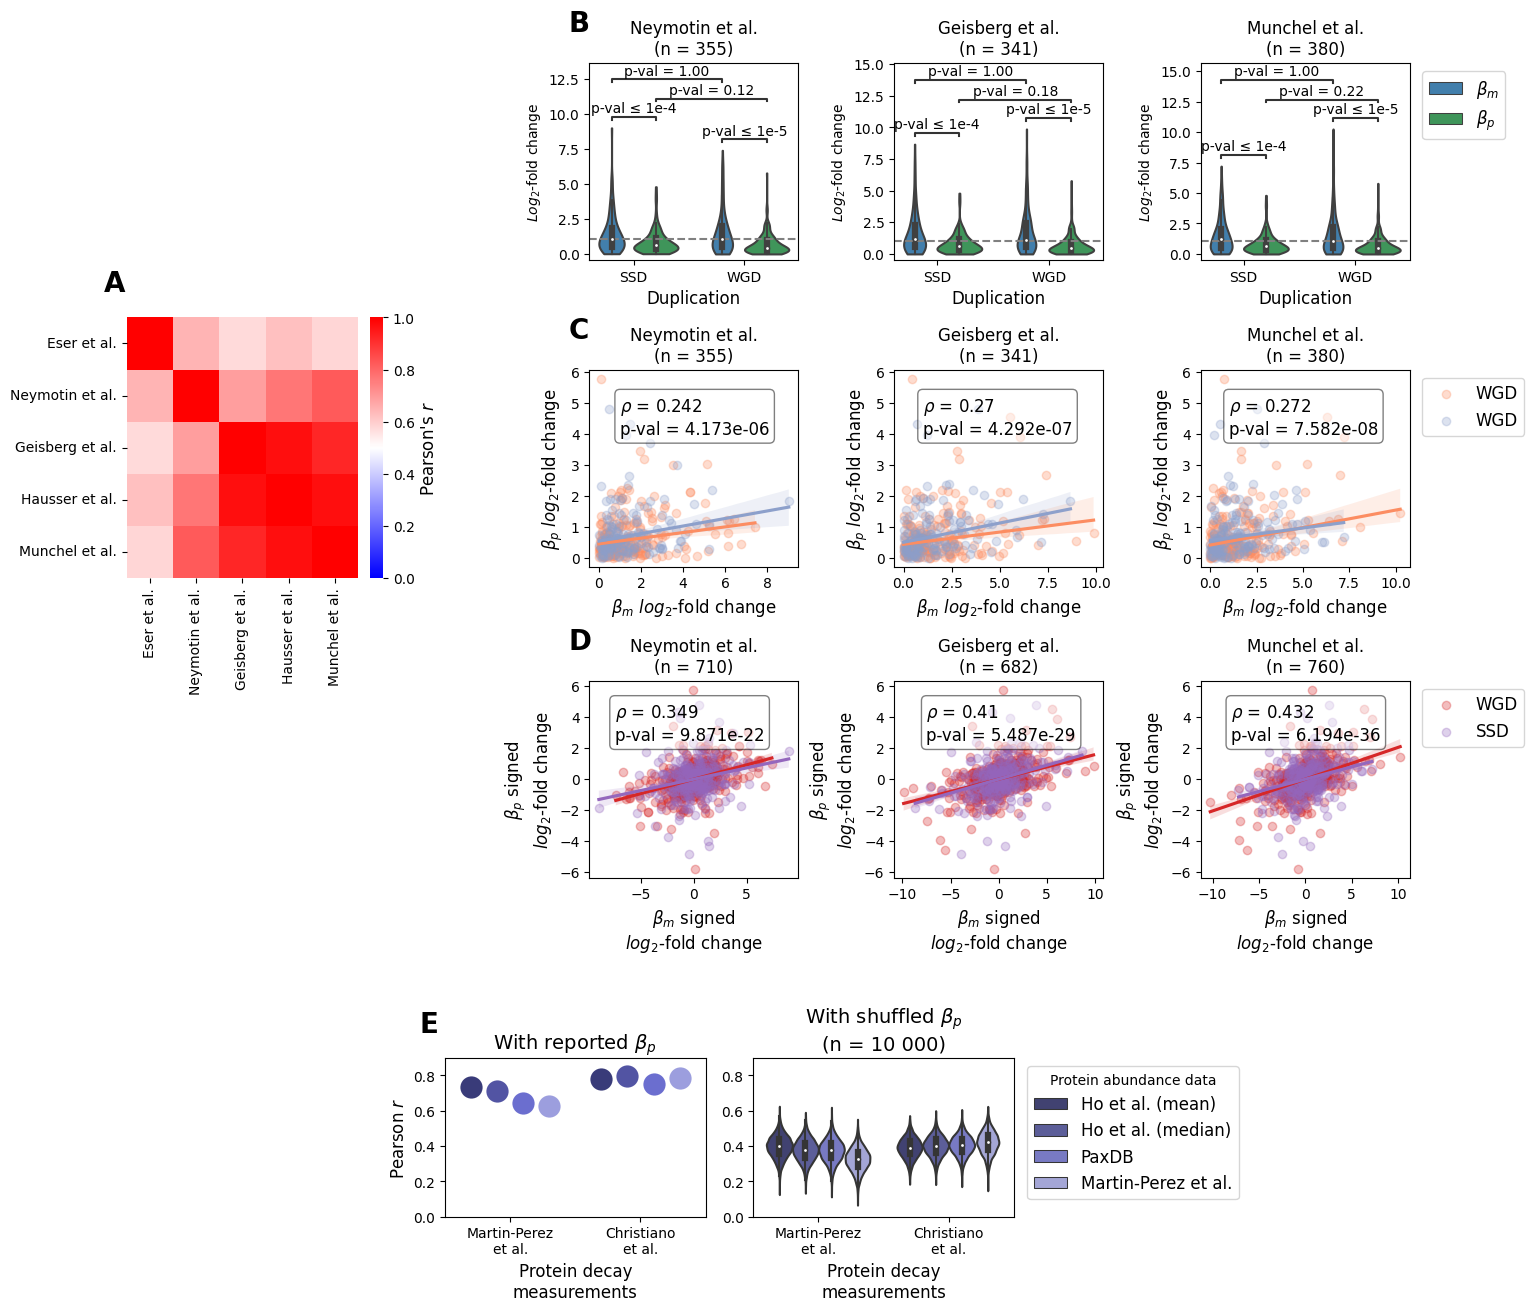

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16, 13))

# Preparation of the grids and axes
gs0 = fig.add_gridspec(30, 28)

gs00 = gs0[0:22, 0:9].subgridspec(9, 8)
gs01 = gs0[0:22, 10:].subgridspec(3, 3)
gs02 = gs0[23:, 8:23].subgridspec(1, 2)

ax0 = fig.add_subplot(gs00[3:6, 2:8])

# Dictionary of axes for the right part
axes_dict = {}

for a in range(3):
    for b in range(3):
        ax = fig.add_subplot(gs01[a, b])
        axes_dict[f'({a}, {b})'] = ax

# Addition of the two axes for the E panel
axes_e = {}

ax = fig.add_subplot(gs02[0])
axes_e['(0)'] = ax

ax = fig.add_subplot(gs02[1])
axes_e['(1)'] = ax

# Plotting

# Panel A: Correlations between datasets
heat_corr = sns.heatmap(corrs_bm, cmap='bwr', vmin=0, vmax=1,
                        ax=ax0)
ax0.annotate('A', (-0.1, 1.1), xycoords='axes fraction',
             fontsize=20, fontweight="bold")
cbar = ax0.collections[0].colorbar
cbar.set_label(r"Pearson's $r$", fontsize=12)

# Panel B: Violin plots of relative divergence
col_bm = ['Bm_Neymotin_fold', 'Bm_Geisberg_fold', 'Bm_Munchel_fold']

title_dict = {'Bm_Neymotin_fold': 'Neymotin et al.', 
              'Bm_Geisberg_fold': 'Geisberg et al.',
              'Bm_Munchel_fold': 'Munchel et al.'}

rates_vars = {'Transcription rate': r"$\beta_m$", 
              'Translation rate': r"$\beta_p$"}

med_bm = np.median(rates_decay['bm_fold_original'])

n_fig = 0
coords = ['(0, 0)', '(0, 1)', '(0, 2)', '(0, 3)']

while n_fig < 3:

  log_fold = rates_decay[['Duplication', col_bm[n_fig], 'bp_fold_original']].copy()
  
  log_fold.columns = ['Duplication', 'Transcription rate', 'Translation rate']

  log_fold = log_fold.dropna(subset=['Transcription rate', 'Translation rate'])

  n_data = log_fold.shape[0]
  
  data_fold = log_fold.melt(id_vars=['Duplication'],
                            value_vars=['Transcription rate', 
                                        'Translation rate'],
                            var_name='Property',
                            value_name=r"$Log_{2}$-fold change")
  
  for row in range(data_fold.shape[0]):
    data_fold.at[row, 'Property'] = rates_vars[data_fold.at[row, 'Property']]

  if n_fig == 3:
    fold_def = sns.violinplot(x='Duplication', y=r"$Log_{2}$-fold change", 
                              hue='Property', data=data_fold, cut=0, 
                              palette={r"$\beta_m$": cm.tab20c.colors[0],
                                       r"$\beta_p$": cm.tab20c.colors[8]},
                              ax=axes_dict[coords[n_fig]])
      
    fold_def.legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                    fontsize='x-large')
      
  else:
    fold_def = sns.violinplot(x='Duplication', y=r"$Log_{2}$-fold change",
                              hue='Property', data=data_fold, cut=0, 
                              palette={r"$\beta_m$": cm.tab20c.colors[0],
                                       r"$\beta_p$": cm.tab20c.colors[8]},
                              ax=axes_dict[coords[n_fig]])
    axes_dict[coords[n_fig]].get_legend().remove()

  add_stat_annotation(fold_def, data=data_fold, x='Duplication', 
                      y=r"$Log_{2}$-fold change", hue='Property', 
                      box_pairs=[(('WGD', r"$\beta_m$"), 
                                  ('WGD', r"$\beta_p$")),
                                 (('WGD', r"$\beta_p$"),
                                  ('SSD', r"$\beta_p$")),
                                 (('WGD', r"$\beta_m$"), 
                                  ('SSD', r"$\beta_m$")),
                                 (('SSD', r"$\beta_m$"),
                                  ('SSD', r"$\beta_p$"))],
                      test='Mann-Whitney', text_format='simple', 
                      loc='inside', verbose=0)  

  axes_dict[coords[n_fig]].axhline(y=med_bm, c='grey', linestyle='--')
  axes_dict[coords[n_fig]].set_xlabel('Duplication', fontsize=12)

  axes_dict[coords[n_fig]].set_title(f'{title_dict[col_bm[n_fig]]}\n(n = {n_data})')

  n_fig += 1

axes_dict['(0, 0)'].annotate('B', (-0.1, 1.16), xycoords='axes fraction',
                             fontsize=20, fontweight="bold")

axes_dict['(0, 2)'].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                           fontsize='large')

# Panel C: Correlations of fold-changes
data_WGD = rates_decay[rates_decay['Duplication'] == 'WGD'].copy()
data_SSD = rates_decay[rates_decay['Duplication'] == 'SSD'].copy()

sns.regplot(x='Bm_Neymotin_fold', y='bp_fold_original', data=data_WGD, 
            ax=axes_dict['(1, 0)'], color=cm.Set2.colors[1], 
            scatter_kws={'alpha':0.3}, robust=True)
sns.regplot(x='Bm_Neymotin_fold', y='bp_fold_original', data=data_SSD, 
            ax=axes_dict['(1, 0)'], color=cm.Set2.colors[2], 
            scatter_kws={'alpha':0.3}, robust=True)

data_corr1 = rates_decay.dropna(subset=['Bm_Neymotin_fold', 'bp_fold_original']).copy()
n_corr1 = data_corr1.shape[0]
rho_fold1 = stats.spearmanr(data_corr1['Bm_Neymotin_fold'], 
                            data_corr1['bp_fold_original'])
axes_dict['(1, 0)'].annotate(r"$\rho$ = " f'{round(rho_fold1[0], 3)}\np-val = {rho_fold1[1]:.3e}',
                             (1, 4), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
axes_dict['(1, 0)'].set_title(f'Neymotin et al.\n(n = {n_corr1})')

sns.regplot(x='Bm_Geisberg_fold', y='bp_fold_original', data=data_WGD, 
            ax=axes_dict['(1, 1)'], color=cm.Set2.colors[1], 
            scatter_kws={'alpha':0.3}, robust=True)
sns.regplot(x='Bm_Geisberg_fold', y='bp_fold_original', data=data_SSD, 
            ax=axes_dict['(1, 1)'], color=cm.Set2.colors[2], 
            scatter_kws={'alpha':0.3}, robust=True)

data_corr2 = rates_decay.dropna(subset=['Bm_Geisberg_fold', 'bp_fold_original']).copy()
n_corr2 = data_corr2.shape[0]
rho_fold2 = stats.spearmanr(data_corr2['Bm_Geisberg_fold'], 
                            data_corr2['bp_fold_original'])
axes_dict['(1, 1)'].annotate(r"$\rho$ = " f'{round(rho_fold2[0], 3)}\np-val = {rho_fold2[1]:.3e}',
                             (1, 4), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
axes_dict['(1, 1)'].set_title(f'Geisberg et al.\n(n = {n_corr2})')

sns.regplot(x='Bm_Munchel_fold', y='bp_fold_original', data=data_WGD, 
            label='WGD', ax=axes_dict['(1, 2)'], color=cm.Set2.colors[1], 
            scatter_kws={'alpha':0.3}, robust=True)
sns.regplot(x='Bm_Munchel_fold', y='bp_fold_original', data=data_SSD,
            label='WGD', ax=axes_dict['(1, 2)'], color=cm.Set2.colors[2], 
            scatter_kws={'alpha':0.3}, robust=True)

data_corr3 = rates_decay.dropna(subset=['Bm_Munchel_fold', 'bp_fold_original']).copy()
n_corr3 = data_corr3.shape[0]
rho_fold3 = stats.spearmanr(data_corr3['Bm_Munchel_fold'], 
                            data_corr3['bp_fold_original'])
axes_dict['(1, 2)'].annotate(r"$\rho$ = " f'{round(rho_fold3[0], 3)}\np-val = {rho_fold3[1]:.3e}',
                             (1, 4), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
axes_dict['(1, 2)'].set_title(f'Munchel et al.\n(n = {n_corr3})')

axes_dict['(1, 2)'].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                           fontsize='large')

#sns.regplot(x='bm_fold_Eser', y='bp_fold_original', data=data_WGD, 
            #ax=axes_dict['(1, 3)'], color=cm.Set2.colors[1], label='WGD', 
            #scatter_kws={'alpha':0.3}, robust=True)
#sns.regplot(x='bm_fold_Eser', y='bp_fold_original', data=data_SSD, 
            #ax=axes_dict['(1, 3)'], color=cm.Set2.colors[2], label='SSD', 
            #scatter_kws={'alpha':0.3}, robust=True)

#data_corr4 = rates_decay.dropna(subset=['bm_fold_Eser', 'bp_fold_original']).copy()
#n_corr4 = data_corr4.shape[0]
#rho_fold4 = stats.spearmanr(data_corr4['bm_fold_Eser'], 
                            #data_corr4['bp_fold_original'])
#axes_dict['(1, 3)'].annotate(r"$\rho$ = " f'{round(rho_fold4[0], 3)}\np-val = {rho_fold4[1]:.3e}',
                             #(0.5, 4), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             #fontsize=12)
#axes_dict['(1, 3)'].set_title(f'Eser et al.\n(n = {n_corr4})')

#axes_dict['(1, 3)'].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                           #fontsize='large')

# Axes labels for panel C
for ax in [axes_dict['(1, 0)'], axes_dict['(1, 1)'], axes_dict['(1, 2)']]:
  ax.set_xlabel(r"$\beta_m$ $log_{2}$-fold change", fontsize=12)
  ax.set_ylabel(r"$\beta_p$ $log_{2}$-fold change", fontsize=12)

axes_dict['(1, 0)'].annotate('C', (-0.1, 1.16), xycoords='axes fraction',
                             fontsize=20, fontweight="bold")


# Panel D: Correlations between signed fold-changes
signed_WGD = decay_signed[decay_signed['Duplication'] == 'WGD'].copy()
signed_SSD = decay_signed[decay_signed['Duplication'] == 'SSD'].copy()

sns.regplot(x='Bm_Neymotin_signed', y='bp_fold_signed', data=signed_WGD, 
            ax=axes_dict['(2, 0)'], color=cm.tab10.colors[3], 
            scatter_kws={'alpha':0.3}, robust=True)
sns.regplot(x='Bm_Neymotin_signed', y='bp_fold_signed', data=signed_SSD, 
            ax=axes_dict['(2, 0)'], color=cm.tab10.colors[4], 
            scatter_kws={'alpha':0.3}, robust=True)

data_corr1 = decay_signed.dropna(subset=['Bm_Neymotin_signed', 'bp_fold_signed']).copy()
n_corr1 = data_corr1.shape[0]
rho_fold1 = stats.spearmanr(data_corr1['Bm_Neymotin_signed'], 
                            data_corr1['bp_fold_signed'])
axes_dict['(2, 0)'].annotate(r"$\rho$ = " f'{round(rho_fold1[0], 3)}\np-val = {rho_fold1[1]:.3e}',
                             (-7.5, 2.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
axes_dict['(2, 0)'].set_title(f'Neymotin et al.\n(n = {n_corr1})')

sns.regplot(x='Bm_Geisberg_signed', y='bp_fold_signed', data=signed_WGD, 
            ax=axes_dict['(2, 1)'], color=cm.tab10.colors[3], 
            scatter_kws={'alpha':0.3}, robust=True)
sns.regplot(x='Bm_Geisberg_signed', y='bp_fold_signed', data=signed_SSD, 
            ax=axes_dict['(2, 1)'], color=cm.tab10.colors[4], 
            scatter_kws={'alpha':0.3}, robust=True)

data_corr2 = decay_signed.dropna(subset=['Bm_Geisberg_signed', 'bp_fold_signed']).copy()
n_corr2 = data_corr2.shape[0]
rho_fold2 = stats.spearmanr(data_corr2['Bm_Geisberg_signed'], 
                            data_corr2['bp_fold_signed'])
axes_dict['(2, 1)'].annotate(r"$\rho$ = " f'{round(rho_fold2[0], 3)}\np-val = {rho_fold2[1]:.3e}',
                             (-7.5, 2.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
axes_dict['(2, 1)'].set_title(f'Geisberg et al.\n(n = {n_corr2})')

sns.regplot(x='Bm_Munchel_signed', y='bp_fold_signed', data=signed_WGD, 
            ax=axes_dict['(2, 2)'], color=cm.tab10.colors[3], label='WGD',
            scatter_kws={'alpha':0.3}, robust=True)
sns.regplot(x='Bm_Munchel_signed', y='bp_fold_signed', data=signed_SSD,
            label='SSD', ax=axes_dict['(2, 2)'], color=cm.tab10.colors[4], 
            scatter_kws={'alpha':0.3}, robust=True)

data_corr3 = decay_signed.dropna(subset=['Bm_Munchel_signed', 'bp_fold_signed']).copy()
n_corr3 = data_corr3.shape[0]
rho_fold3 = stats.spearmanr(data_corr3['Bm_Munchel_signed'], 
                            data_corr3['bp_fold_signed'])
axes_dict['(2, 2)'].annotate(r"$\rho$ = " f'{round(rho_fold3[0], 3)}\np-val = {rho_fold3[1]:.3e}',
                             (-8, 2.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
axes_dict['(2, 2)'].set_title(f'Munchel et al.\n(n = {n_corr3})')

axes_dict['(2, 2)'].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                           fontsize='large')

#sns.regplot(x='Bm_Pelechano_signed', y='bp_fold_signed', data=signed_WGD, 
            #ax=axes_dict['(2, 3)'], color=cm.tab10.colors[3], label='WGD', 
            #scatter_kws={'alpha':0.3}, robust=True)
#sns.regplot(x='Bm_Pelechano_signed', y='bp_fold_signed', data=signed_SSD, 
            #ax=axes_dict['(2, 3)'], color=cm.tab10.colors[4], label='SSD', 
            #scatter_kws={'alpha':0.3}, robust=True)

#data_corr4 = decay_signed.dropna(subset=['Bm_Pelechano_signed', 'bp_fold_signed']).copy()
#n_corr4 = data_corr4.shape[0]
#rho_fold4 = stats.spearmanr(data_corr4['Bm_Pelechano_signed'], 
                            #data_corr4['bp_fold_signed'])
#axes_dict['(2, 3)'].annotate(r"$\rho$ = " f'{round(rho_fold4[0], 3)}\np-val = {rho_fold4[1]:.3e}',
                             #(-5, 2.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             #fontsize=12)
#axes_dict['(2, 3)'].set_title(f'Pelechano et al.\n(n = {n_corr4})')

#axes_dict['(2, 3)'].legend(loc='upper left', bbox_to_anchor=(1.02, 1),
                           #fontsize='large')

# Axes labels for panel D
for ax in [axes_dict['(2, 0)'], axes_dict['(2, 1)'], axes_dict['(2, 2)']]:
  ax.set_xlabel(r"$\beta_m$ signed"'\n'r"$log_{2}$-fold change", fontsize=12)
  ax.set_ylabel(r"$\beta_p$ signed"'\n'r"$log_{2}$-fold change", fontsize=12)


axes_dict['(2, 0)'].annotate('D', (-0.1, 1.16), xycoords='axes fraction',
                             fontsize=20, fontweight="bold")

# Panel E: Correlations between estimated and measured log2-fold changes
# of protein abundance
palette_e = {'Ho et al. (mean)': cm.tab20b.colors[0], 
             'Ho et al. (median)': cm.tab20b.colors[1],
             'PaxDB': cm.tab20b.colors[2],
             'Martin-Perez et al.': cm.tab20b.colors[3]}
hue_order_e = ['Ho et al. (mean)', 'Ho et al. (median)', 'PaxDB',
               'Martin-Perez et al.']

true_vals = sns.swarmplot(x='Decay_data', y='pearson_r', hue='Protein abundance',
                          data=corrs_true, dodge=True, size=16, 
                          hue_order=hue_order_e, palette=palette_e, 
                          ax=axes_e['(0)'])
axes_e['(0)'].set_ylim(0, 0.90)
axes_e['(0)'].set_ylabel(r"Pearson $r$", fontsize=12)
axes_e['(0)'].set_xlabel('Protein decay\nmeasurements', fontsize=12)
axes_e['(0)'].legend([],[], frameon=False)
axes_e['(0)'].set_title(r"With reported $\beta_p$", fontsize=14)

df_pEst = df_pEst.infer_objects()
sims_corrs = sns.violinplot(x='Decay_data', y='pearson_r', hue='Protein abundance',
                            data=df_pEst, hue_order=hue_order_e,
                            palette=palette_e, cut=0, ax=axes_e['(1)'])
axes_e['(1)'].set_ylim(0, 0.90)
axes_e['(1)'].set_title(r"With shuffled $\beta_p$" '\n(n = 10 000)', fontsize=14)
axes_e['(1)'].set_ylabel('')
axes_e['(1)'].set_xlabel('Protein decay\nmeasurements', fontsize=12)

sims_corrs.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='large',
                  title='Protein abundance data')

axes_e['(0)'].annotate('E', (-0.1, 1.16), xycoords='axes fraction',
                       fontsize=20, fontweight="bold")

FigS1 = plt.gcf()
#FigS1.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS1.pdf', bbox_inches='tight')
FigS1.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS1.tiff', bbox_inches='tight')

In [ ]:
df_pEst.groupby(by=['Decay_data', 'Protein abundance'], as_index=False).max()

,Decay_data,Protein abundance,Num,pearson_r
0,Christiano\net al.,Ho et al. (mean),9999,0.572550
1,Christiano\net al.,Ho et al. (median),9999,0.600510
2,Christiano\net al.,Martin-Perez et al.,9999,0.624947
3,Christiano\net al.,PaxDB,9999,0.607031
4,Martin-Perez\net al.,Ho et al. (mean),9999,0.625774
5,Martin-Perez\net al.,Ho et al. (median),9999,0.591222
6,Martin-Perez\net al.,Martin-Perez et al.,9999,0.552035
7,Martin-Perez\net al.,PaxDB,9999,0.619919


In [ ]:
corrs_true

,Decay_data,Protein abundance,pearson_r
0,Martin-Perez\net al.,Ho et al. (mean),0.735761
1,Martin-Perez\net al.,Ho et al. (median),0.713397
2,Martin-Perez\net al.,PaxDB,0.644245
3,Martin-Perez\net al.,Martin-Perez et al.,0.626673
4,Christiano\net al.,Ho et al. (mean),0.782614
5,Christiano\net al.,Ho et al. (median),0.79758
6,Christiano\net al.,PaxDB,0.752321
7,Christiano\net al.,Martin-Perez et al.,0.785892


## Construction of Figure S2

### Generating simulated data assuming different levels of experimental noise

In [ ]:
# Definition of the simulation method
# This function also allows to specify and mRNA decay dataset from which to
# sample am values, which will be used for Figure S3
def sim_decay(fold_bm, fold_bp, cv_m=0, cv_wRPF=0, am_data=False,
              data=rates_pairs, signed_data=None, n=10000, seed=42):
  """fold_bm = Standard deviation for the log2-fold changes of Bm
     fold_bp = Standard deviation for the log2-fold changes of Bp
     cv_m = Mean experimental error on mRNA abundances, in %
     cv_wRPF = Mean experimental error on ribosomal footprint abundances, in %
     am_data = Dataset of mRNA decay constants to use. If set to False,
               variations in mRNA decay will be neglected
     data = Dataframe containing ['bm_P1', 'bm_P2', 'bp_P1', 'bp_P2'], from
            which to sample transcription and translation rates
     signed_data = Dataframe of signed fold-changes, from which to sample mRNA
                   decay divergence. Only used if am_data not set to False
     n = Number of paralog pairs
     seed = Seed of the random number generator"""
  
  # Initalizing a random number generator
  rng = np.random.default_rng(seed)

  # Initializing dictionaries for the specificaton of an mRNA decay dataset
  am_num_dict = {'Eser': 'amEser', 'Neymotin': 'am_Neymotin', 
                 'Geisberg': 'am_Geisberg', 'Munchel': 'am_Munchel'}
  am_fold_dict = {'Eser': 'amEser_signed', 'Neymotin': 'am_Neymotin_signed',
                  'Geisberg': 'am_Geisberg_signed', 
                  'Munchel': 'am_Munchel_signed'}

  # Generating data for P1
  P1_Bm = rng.choice(np.concatenate([data['bm_P1'], data['bm_P2']]), n)
  P1_Bp = rng.choice(np.concatenate([data['bp_P1'], data['bp_P2']]), n)

  if am_data:
    col_am_P1 = f'{am_num_dict[am_data]}_P1'
    col_am_P2 = f'{am_num_dict[am_data]}_P2'
    am_set = np.concatenate([signed_data[col_am_P1].dropna(),
                             signed_data[col_am_P2].dropna()])
    
    P1_am = rng.choice(am_set, n)

  # Generating the dataset for the n simulated pairs
  set_pairs = pd.DataFrame(columns=['Bm_P1', 'Bm_P2', 'Bp_P1', 'Bp_P2',
                                    'am_P1', 'am_P2'])

  set_pairs['Bm_P1'] = P1_Bm
  set_pairs['Bp_P1'] = P1_Bp

  # Bm and Bp divergence with randomized log2 fold_changes
  changes_bm = rng.normal(0, fold_bm, n)
  changes_bp = rng.normal(0, fold_bp, n)

  set_pairs['Bm_P2'] = np.log10(2**changes_bm * (10**set_pairs['Bm_P1']))
  set_pairs['Bp_P2'] = np.log10(2**changes_bp * (10**set_pairs['Bp_P1']))

  # mRNA decay divergence with realistic fold-changes (if applicable)
  if am_data:
    set_pairs['am_P1'] = P1_am
    
    changes_am = rng.choice(signed_data[am_fold_dict[am_data]].dropna(), n)
    set_pairs['am_P2'] = np.log10(2**changes_am * (10**set_pairs['am_P1']))

  else:
    set_pairs['am_P1'] = 5.1
    set_pairs['am_P1'] = np.log10(set_pairs['am_P1'])
    set_pairs['am_P2'] = set_pairs['am_P1']

  # The real and apparent Bm and Bp fold-changes are computed
  folds_comp = pd.DataFrame(columns=['Bm_P1', 'Bm_app_P1', 'Bm_P2', 'Bm_app_P2',
                                     'Bm_fold_real', 'Bm_fold_app', 'Bp_P1',
                                     'Bp_app_P1', 'Bp_P2', 'Bp_app_P2',
                                     'Bp_fold_real', 'Bp_fold_app',
                                     'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF',
                                     'am_dataset'])
  
  folds_comp['Bm_P1'] = set_pairs['Bm_P1']
  folds_comp['Bm_P2'] = set_pairs['Bm_P2']
  folds_comp['Bp_P1'] = set_pairs['Bp_P1']
  folds_comp['Bp_P2'] = set_pairs['Bp_P2']
  
  # Real fold-changes
  folds_comp = fold_change('Bm_P1', 'Bm_P2', folds_comp, 'Bm_fold_real')
  folds_comp = fold_change('Bp_P1', 'Bp_P2', folds_comp, 'Bp_fold_real')

  # Apparent fold-changes (potentially accounting for experimental noise)
  # First, conversion to experimental measurements (m and wRPF)
  m_P1 = 10**set_pairs['Bm_P1'] / 10**set_pairs['am_P1']
  wRPF_P1 = 10**set_pairs['Bp_P1'] * m_P1

  m_P2 = 10**set_pairs['Bm_P2'] / 10**set_pairs['am_P2']
  wRPF_P2 = 10**set_pairs['Bp_P2'] * m_P2

  # Then, adding noise to both measures
  var_m_P1 = rng.normal(0, cv_m/100, n)
  m_noise_P1 = m_P1 + (m_P1 * var_m_P1)
  
  var_wRPF_P1 = rng.normal(0, cv_wRPF/100, n)
  wRPF_noise_P1 = wRPF_P1 + (wRPF_P1 * var_wRPF_P1)

  var_m_P2 = rng.normal(0, cv_m/100, n)
  m_noise_P2 = m_P2 + (m_P2 * var_m_P2)
  
  var_wRPF_P2 = rng.normal(0, cv_wRPF/100, n)
  wRPF_noise_P2 = wRPF_P2 + (wRPF_P2 * var_wRPF_P2)

  # Finally, recalculating the apparent Bm and Bp rates (considering exp noise
  # and under the assumption of constant mRNA decay rates)
  Bm_P1_app = np.log10(m_noise_P1 * 5.1)
  folds_comp['Bm_app_P1'] = Bm_P1_app
  Bm_P2_app = np.log10(m_noise_P2 * 5.1)
  folds_comp['Bm_app_P2'] = Bm_P2_app
  folds_comp = fold_change('Bm_app_P1', 'Bm_app_P2', folds_comp, 'Bm_fold_app')

  Bp_P1_app = np.log10((wRPF_noise_P1/m_noise_P1))
  folds_comp['Bp_app_P1'] = Bp_P1_app
  Bp_P2_app = np.log10((wRPF_noise_P2/m_noise_P2))
  folds_comp['Bp_app_P2'] = Bp_P2_app
  folds_comp = fold_change('Bp_app_P1', 'Bp_app_P2', folds_comp, 'Bp_fold_app')

  # Addition of parameters
  folds_comp['fold_bm'] = fold_bm
  folds_comp['fold_bp'] = fold_bp
  folds_comp['cv_m'] = cv_m
  folds_comp['cv_wRPF'] = cv_wRPF

  if am_data:
    folds_comp['am_dataset'] = am_data

  else:
    folds_comp['am_dataset'] = 'None'

  return folds_comp

What is the variance (and standard deviation) of the empirical distribution of (signed) log2-fold changes in transcription and in translation? This will guide the simulations below.

In [ ]:
sd_bm = np.std(Signed_all['Bm_signed'])
var_bm = np.var(Signed_all['Bm_signed'])

print('Bm log2-fold changes:''\n'f'sd = {sd_bm}''\n'f'var = {var_bm}')

Bm log2-fold changes:
sd = 2.2947835439633564
var = 5.266031513645021


<Axes: xlabel='Bm_signed', ylabel='Density'>

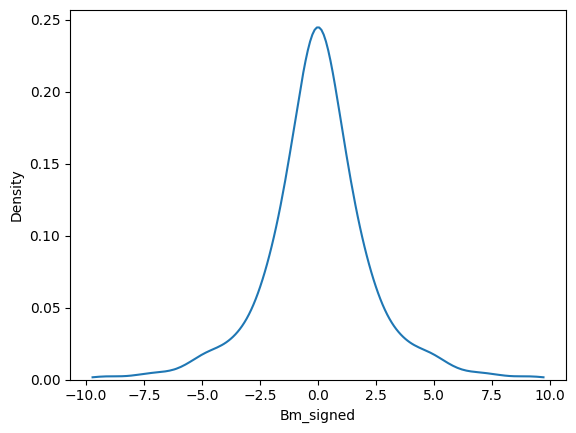

In [ ]:
sns.kdeplot(Signed_all.reset_index(drop=True)['Bm_signed'], cut=0)

<Axes: xlabel='Bp_signed', ylabel='Density'>

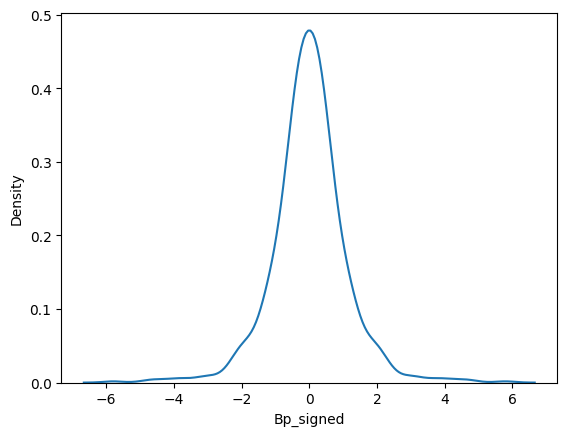

In [ ]:
sns.kdeplot(Signed_all.reset_index(drop=True)['Bp_signed'])

In [ ]:
sd_bp = np.std(Signed_all['Bp_signed'])
var_bp = np.var(Signed_all['Bp_signed'])

print('Bp log2-fold changes:''\n'f'sd = {sd_bp}''\n'f'var = {var_bp}')

Bp log2-fold changes:
sd = 1.107087344522256
var = 1.2256423884013405


In [ ]:
# Mean of the SD
mean_sd = math.sqrt((var_bm + var_bp)/2)
print(mean_sd)

1.8016206457029684


The simulated data is generated:

In [ ]:
# Definition of dataframes for each of the three scenarios
mock_model = pd.DataFrame(columns=['Bm_P1', 'Bm_app_P1', 'Bm_P2', 'Bm_app_P2',
                                     'Bm_fold_real', 'Bm_fold_app', 'Bp_P1',
                                     'Bp_app_P1', 'Bp_P2', 'Bp_app_P2',
                                     'Bp_fold_real', 'Bp_fold_app',
                                     'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF',
                                     'am_dataset'])
mock_equal = mock_model.copy()
mock_Bm = mock_model.copy()
mock_Bp = mock_model.copy()

# For panel B
mock_Bp_1211 = mock_model.copy()
mock_Bp_65 = mock_model.copy()
mock_Bp_32 = mock_model.copy()
mock_Bp_2 = mock_model.copy()
mock_Bp_3 = mock_model.copy()
mock_Bp_6 = mock_model.copy()

# For panel C (considering that Bm divergence is equal to Bp divergence)
mock_Bm010 = mock_model.copy()
mock_Bm025 = mock_model.copy()
mock_Bm050 = mock_model.copy()
mock_Bm1 = mock_model.copy()
mock_Bm2 = mock_model.copy()
mock_Bm3 = mock_model.copy()

# Simulations for various levels of experimental noise
cv_list = [0, 1, 3, 5, 7, 10, 12, 15, 20, 25]

for cv_m in cv_list:

  for cv_wRPF in cv_list:

    # Panel A
    equal_current = sim_decay(mean_sd, mean_sd, cv_m, cv_wRPF)
    mock_equal = pd.concat([mock_equal, equal_current])
    Bm_current = sim_decay(sd_bm, sd_bp, cv_m, cv_wRPF)
    mock_Bm = pd.concat([mock_Bm, Bm_current])
    Bp_current = sim_decay(sd_bp, sd_bm, cv_m, cv_wRPF)
    mock_Bp = pd.concat([mock_Bp, Bp_current])

    # Panel B (at constant variance, equal to the summed variances of Bm and Bp
    # log2-fold changes distributions)
    var_sum = var_bm + var_bp
    Bp_1211_current = sim_decay((math.sqrt(var_sum / (12/11)**2 +1)),
                                ((12/11) * math.sqrt(var_sum / (12/11)**2 +1)),
                                cv_m, cv_wRPF)
    mock_Bp_1211 = pd.concat([mock_Bp_1211, Bp_1211_current])
    Bp_65_current = sim_decay((math.sqrt(var_sum / (6/5)**2 +1)),
                                ((6/5) * math.sqrt(var_sum / (6/5)**2 +1)),
                                cv_m, cv_wRPF)
    mock_Bp_65 = pd.concat([mock_Bp_65, Bp_65_current])
    Bp_32_current = sim_decay((math.sqrt(var_sum / (3/2)**2 +1)),
                              ((3/2) * math.sqrt(var_sum / (3/2)**2 +1)),
                              cv_m, cv_wRPF)
    mock_Bp_32 = pd.concat([mock_Bp_32, Bp_32_current])
    Bp_2_current = sim_decay((math.sqrt(var_sum / (2)**2 +1)),
                              ((2) * math.sqrt(var_sum / (2)**2 +1)),
                              cv_m, cv_wRPF)
    mock_Bp_2 = pd.concat([mock_Bp_2, Bp_2_current])
    Bp_3_current = sim_decay((math.sqrt(var_sum / (3)**2 +1)),
                             ((3) * math.sqrt(var_sum / (3)**2 +1)),
                             cv_m, cv_wRPF)
    mock_Bp_3 = pd.concat([mock_Bp_3, Bp_3_current])
    Bp_6_current = sim_decay((math.sqrt(var_sum / (6)**2 +1)),
                             ((6) * math.sqrt(var_sum / (6)**2 +1)),
                             cv_m, cv_wRPF)
    mock_Bp_6 = pd.concat([mock_Bp_6, Bp_6_current])

    # Panel C (varying the mean cumulative divergence while keeping the 
    # Bm and Bp contributions equal)
    Bm_010_current = sim_decay((0.1), (0.1), cv_m, cv_wRPF)
    mock_Bm010 = pd.concat([mock_Bm010, Bm_010_current])
    Bm_025_current = sim_decay((0.25), (0.25), cv_m, cv_wRPF)
    mock_Bm025 = pd.concat([mock_Bm025, Bm_025_current])
    Bm_050_current = sim_decay((0.5), (0.5), cv_m, cv_wRPF)
    mock_Bm050 = pd.concat([mock_Bm050, Bm_050_current])
    Bm_1_current = sim_decay((1), (1), cv_m, cv_wRPF)
    mock_Bm1 = pd.concat([mock_Bm1, Bm_1_current])
    Bm_2_current = sim_decay((2), (2), cv_m, cv_wRPF)
    mock_Bm2 = pd.concat([mock_Bm2, Bm_2_current])
    Bm_3_current = sim_decay((3), (3), cv_m, cv_wRPF)
    mock_Bm3 = pd.concat([mock_Bm3, Bm_3_current])

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = geta

*In some rare cases, the randomly sampled error will be greater than the true value, resulting in a negative value which is invalid for the log10 function and results into an NaN 

In [ ]:
# Processing the data and computing median divergence ratios
# First with equal divergences
mock_equal['Ratio'] = 2**mock_equal['Bm_fold_app'] / 2**mock_equal['Bp_fold_app']
equal_med = mock_equal[['Ratio', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_equal_med = equal_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

# Then for a larger transcriptional divergence
mock_Bm['Ratio'] = 2**mock_Bm['Bm_fold_app'] / 2**mock_Bm['Bp_fold_app']
mock_Bm['Ratio_true'] = 2**mock_Bm['Bm_fold_real'] / 2**mock_Bm['Bp_fold_real']
true_Bm = mock_Bm['Ratio_true'].median()
Bm_med = mock_Bm[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm_med = Bm_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')
mat_Bm_true = Bm_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio_true')

# Finally, for a larger translational divergence
mock_Bp['Ratio'] = 2**mock_Bp['Bm_fold_app'] / 2**mock_Bp['Bp_fold_app']
mock_Bp['Ratio_true'] = 2**mock_Bp['Bm_fold_real'] / 2**mock_Bp['Bp_fold_real']
true_Bp = mock_Bp['Ratio_true'].median()
Bp_med = mock_Bp[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_med = Bp_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')
mat_Bp_true = Bm_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio_true')

# For panel B
mock_Bp_1211['Ratio'] = 2**mock_Bp_1211['Bm_fold_app'] / 2**mock_Bp_1211['Bp_fold_app']
mock_Bp_1211['Ratio_true'] = 2**mock_Bp_1211['Bm_fold_real'] / 2**mock_Bp_1211['Bp_fold_real']
true_Bp_1211 = mock_Bp_1211['Ratio_true'].median()
Bp_1211_med = mock_Bp_1211[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_1211_med = Bp_1211_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bp_65['Ratio'] = 2**mock_Bp_65['Bm_fold_app'] / 2**mock_Bp_65['Bp_fold_app']
mock_Bp_65['Ratio_true'] = 2**mock_Bp_65['Bm_fold_real'] / 2**mock_Bp_65['Bp_fold_real']
true_Bp_65 = mock_Bp_65['Ratio_true'].median()
Bp_65_med = mock_Bp_65[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_65_med = Bp_65_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bp_32['Ratio'] = 2**mock_Bp_32['Bm_fold_app'] / 2**mock_Bp_32['Bp_fold_app']
mock_Bp_32['Ratio_true'] = 2**mock_Bp_32['Bm_fold_real'] / 2**mock_Bp_32['Bp_fold_real']
true_Bp_32 = mock_Bp_32['Ratio_true'].median()
Bp_32_med = mock_Bp_32[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_32_med = Bp_32_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bp_2['Ratio'] = 2**mock_Bp_2['Bm_fold_app'] / 2**mock_Bp_2['Bp_fold_app']
mock_Bp_2['Ratio_true'] = 2**mock_Bp_2['Bm_fold_real'] / 2**mock_Bp_2['Bp_fold_real']
true_Bp_2 = mock_Bp_2['Ratio_true'].median()
Bp_2_med = mock_Bp_2[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_2_med = Bp_2_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bp_3['Ratio'] = 2**mock_Bp_3['Bm_fold_app'] / 2**mock_Bp_3['Bp_fold_app']
mock_Bp_3['Ratio_true'] = 2**mock_Bp_3['Bm_fold_real'] / 2**mock_Bp_3['Bp_fold_real']
true_Bp_3 = mock_Bp_3['Ratio_true'].median()
Bp_3_med = mock_Bp_3[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_3_med = Bp_3_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bp_6['Ratio'] = 2**mock_Bp_6['Bm_fold_app'] / 2**mock_Bp_6['Bp_fold_app']
mock_Bp_6['Ratio_true'] = 2**mock_Bp_6['Bm_fold_real'] / 2**mock_Bp_6['Bp_fold_real']
true_Bp_6 = mock_Bp_6['Ratio_true'].median()
Bp_6_med = mock_Bp_6[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bp_6_med = Bp_6_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

# For panel C
mock_Bm010['Ratio'] = 2**mock_Bm010['Bm_fold_app'] / 2**mock_Bm010['Bp_fold_app']
mock_Bm010['Ratio_true'] = 2**mock_Bm010['Bm_fold_real'] / 2**mock_Bm010['Bp_fold_real']
true_Bm010 = mock_Bm010['Ratio_true'].median()
Bm010_med = mock_Bm010[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm010_med = Bm010_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bm025['Ratio'] = 2**mock_Bm025['Bm_fold_app'] / 2**mock_Bm025['Bp_fold_app']
mock_Bm025['Ratio_true'] = 2**mock_Bm025['Bm_fold_real'] / 2**mock_Bm025['Bp_fold_real']
true_Bm025 = mock_Bm025['Ratio_true'].median()
Bm025_med = mock_Bm025[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm025_med = Bm025_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bm050['Ratio'] = 2**mock_Bm050['Bm_fold_app'] / 2**mock_Bm050['Bp_fold_app']
mock_Bm050['Ratio_true'] = 2**mock_Bm050['Bm_fold_real'] / 2**mock_Bm050['Bp_fold_real']
true_Bm050 = mock_Bm050['Ratio_true'].median()
Bm050_med = mock_Bm050[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm050_med = Bm050_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bm1['Ratio'] = 2**mock_Bm1['Bm_fold_app'] / 2**mock_Bm1['Bp_fold_app']
mock_Bm1['Ratio_true'] = 2**mock_Bm1['Bm_fold_real'] / 2**mock_Bm1['Bp_fold_real']
true_Bm1 = mock_Bm1['Ratio_true'].median()
Bm1_med = mock_Bm1[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm1_med = Bm1_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bm2['Ratio'] = 2**mock_Bm2['Bm_fold_app'] / 2**mock_Bm2['Bp_fold_app']
mock_Bm2['Ratio_true'] = 2**mock_Bm2['Bm_fold_real'] / 2**mock_Bm2['Bp_fold_real']
true_Bm2 = mock_Bm2['Ratio_true'].median()
Bm2_med = mock_Bm2[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm2_med = Bm2_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

mock_Bm3['Ratio'] = 2**mock_Bm3['Bm_fold_app'] / 2**mock_Bm3['Bp_fold_app']
mock_Bm3['Ratio_true'] = 2**mock_Bm3['Bm_fold_real'] / 2**mock_Bm3['Bp_fold_real']
true_Bm3 = mock_Bm3['Ratio_true'].median()
Bm3_med = mock_Bm3[['Ratio', 'Ratio_true', 'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF'], as_index=False).median()
mat_Bm3_med = Bm3_med.pivot(index='cv_m', columns='cv_wRPF', values='Ratio')

In [ ]:
# The y axis of each matrix is flipped
cv_reorder = cv_list
cv_reorder.reverse()

mat_equal_reorder = mat_equal_med.reindex(labels=cv_reorder, axis='rows')
mat_Bm_reorder = mat_Bm_med.reindex(labels=cv_reorder, axis='rows')
mat_Bp_reorder = mat_Bp_med.reindex(labels=cv_reorder, axis='rows')

# For panel B
mat_Bp_1211_med = mat_Bp_1211_med.reindex(labels=cv_reorder, axis='rows')
mat_Bp_65_med = mat_Bp_65_med.reindex(labels=cv_reorder, axis='rows')
mat_Bp_32_med = mat_Bp_32_med.reindex(labels=cv_reorder, axis='rows')
mat_Bp_2_med = mat_Bp_2_med.reindex(labels=cv_reorder, axis='rows')
mat_Bp_3_med = mat_Bp_3_med.reindex(labels=cv_reorder, axis='rows')
mat_Bp_6_med = mat_Bp_6_med.reindex(labels=cv_reorder, axis='rows')

# For panel C
mat_Bm010_med = mat_Bm010_med.reindex(labels=cv_reorder, axis='rows')
mat_Bm025_med = mat_Bm025_med.reindex(labels=cv_reorder, axis='rows')
mat_Bm050_med = mat_Bm050_med.reindex(labels=cv_reorder, axis='rows')
mat_Bm1_med = mat_Bm1_med.reindex(labels=cv_reorder, axis='rows')
mat_Bm2_med = mat_Bm2_med.reindex(labels=cv_reorder, axis='rows')
mat_Bm3_med = mat_Bm3_med.reindex(labels=cv_reorder, axis='rows')

### Constructing the figure

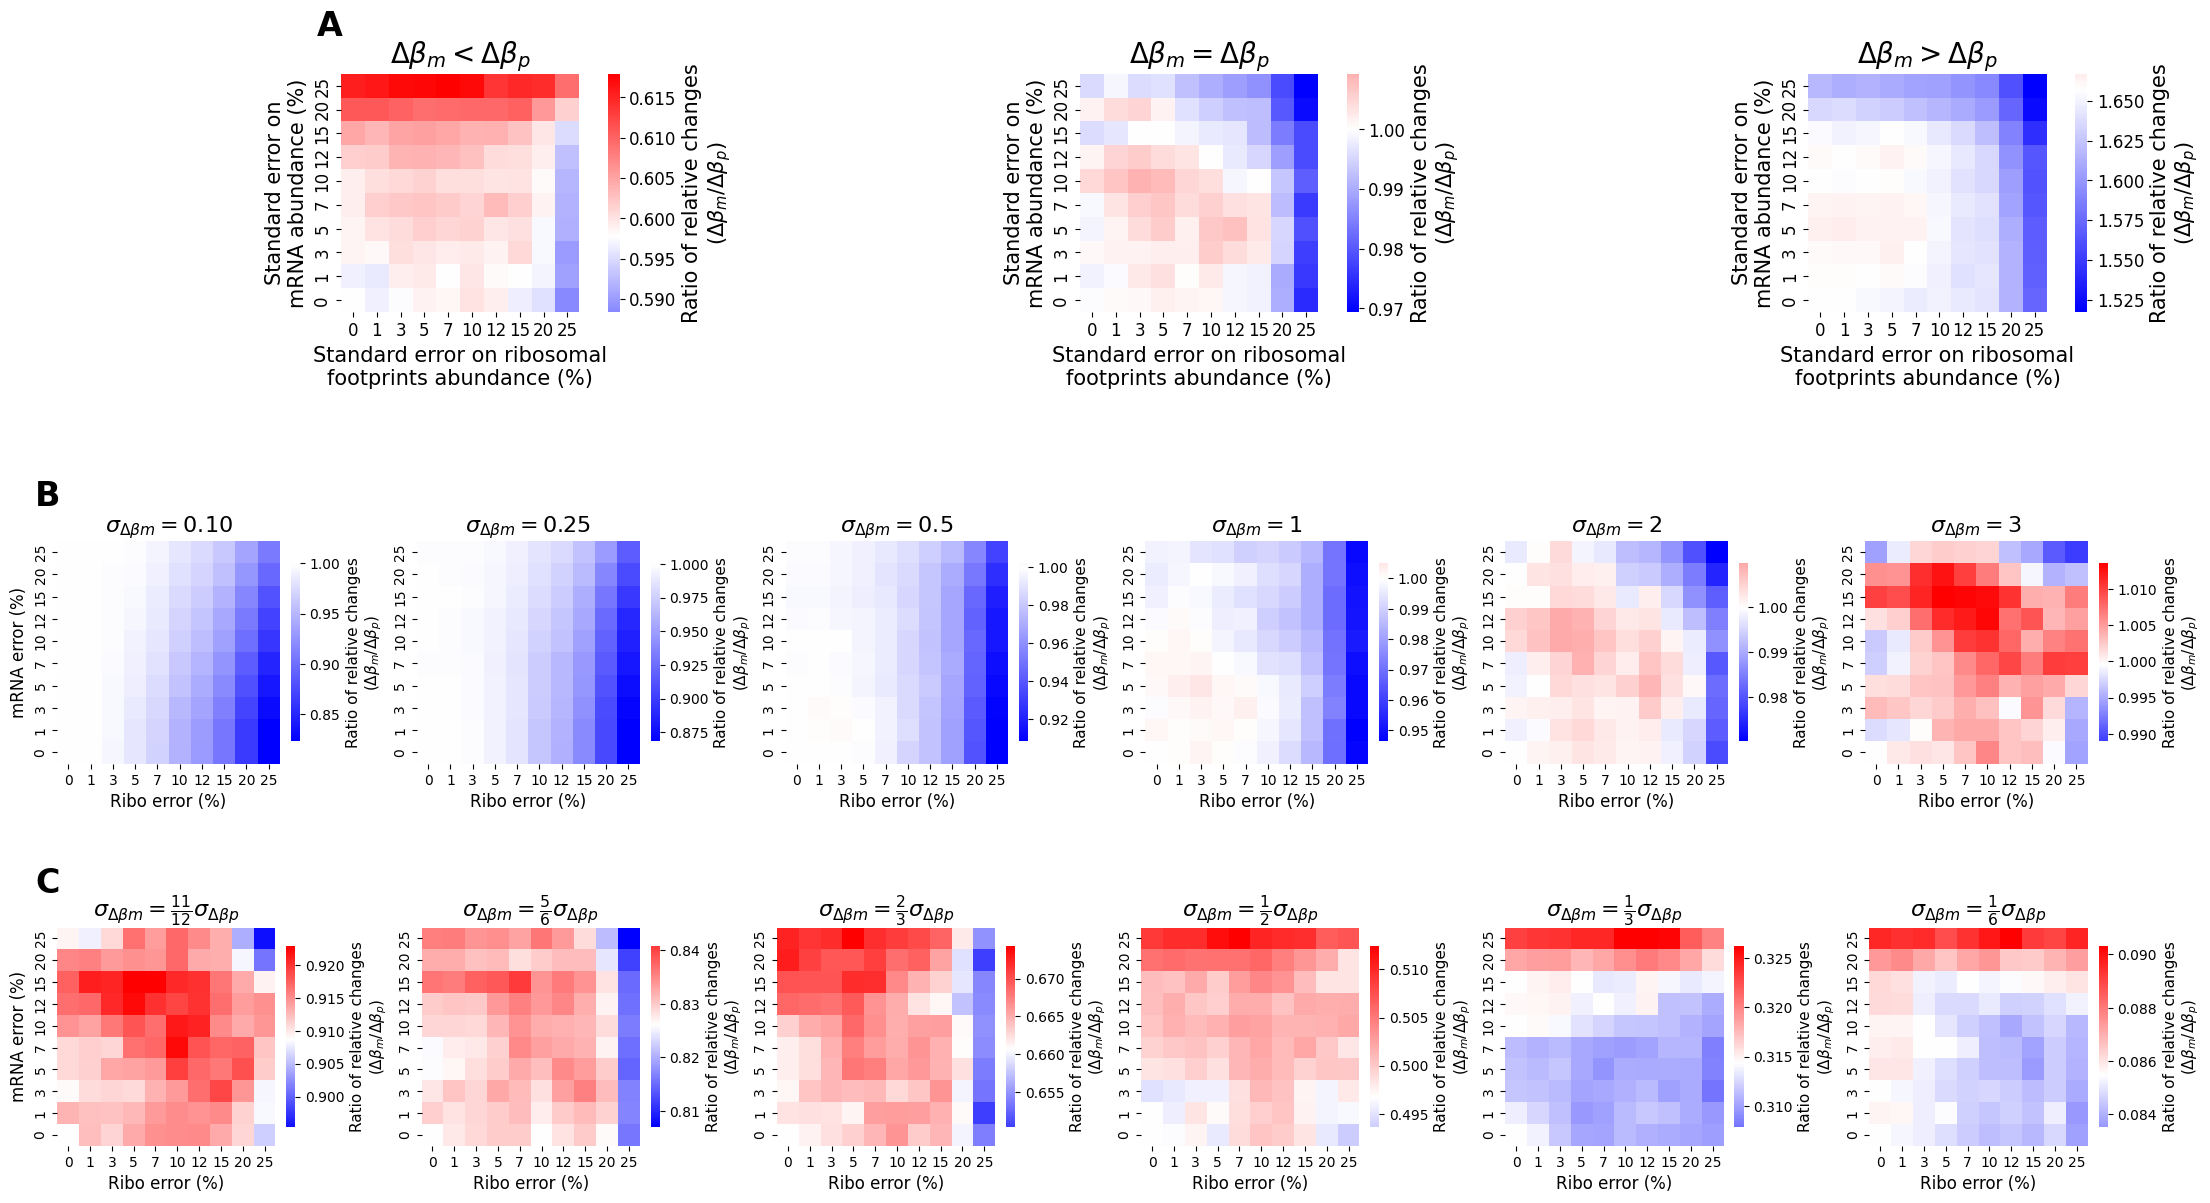

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(22, 12))

# Preparation of the grids and axes
gs0 = fig.add_gridspec(31, 11)

gs00 = gs0[0:10, :].subgridspec(1, 3)
gs01 = gs0[12:21, :].subgridspec(1, 6)
gs02 = gs0[22:31, :].subgridspec(1, 6)

# Dictionaries of axes for each part
axes_dict_top = {}
axes_dict_mid = {}
axes_dict_bot = {}

#axes_dict_top['(0)'] = fig.add_subplot(gs00[1:3])
#axes_dict_top['(1)'] = fig.add_subplot(gs00[4:6])
#axes_dict_top['(2)'] = fig.add_subplot(gs00[7:9])

for a in range(3):
  ax = fig.add_subplot(gs00[a])
  axes_dict_top[f'({a})'] = ax

for a in range(6):
  ax = fig.add_subplot(gs01[a])
  axes_dict_mid[f'({a})'] = ax

for a in range(6):
  ax = fig.add_subplot(gs02[a])
  axes_dict_bot[f'({a})'] = ax

# Heatmaps for the top part
bar_lab = r"Ratio of relative changes"'\n'r"($\beta_m$/$\beta_p$)"

heat1 = sns.heatmap(mat_Bp_reorder, center=true_Bp, cmap='bwr',
                    ax=axes_dict_top['(0)'], cbar_kws={'label':bar_lab}, 
                    square=True)

heat2 = sns.heatmap(mat_equal_reorder, center=1, cmap='bwr',
                    ax=axes_dict_top['(1)'], cbar_kws={'label':bar_lab},
                    square=True)

heat3 = sns.heatmap(mat_Bm_reorder, center=true_Bm, cmap='bwr',
                    ax=axes_dict_top['(2)'], cbar_kws={'label':bar_lab},
                    square=True)

# Adjusting axis and color bars ticks and labels
for ax in [axes_dict_top['(0)'], axes_dict_top['(1)'], axes_dict_top['(2)']]:
  ax.tick_params(axis='both', which='major', labelsize=12)

  ax.set_ylabel("Standard error on\nmRNA abundance (%)", fontsize=15)
  ax.set_xlabel("Standard error on ribosomal\nfootprints abundance (%)",
                fontsize=15)

  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=12)
  cbar.set_label(r"Ratio of relative changes"'\n'r"($\Delta\beta_m$/$\Delta\beta_p$)", fontsize=15)

# Adding titles
axes_dict_top['(0)'].set_title(r"$\Delta\beta_m < \Delta\beta_p$", fontsize=20)
axes_dict_top['(1)'].set_title(r"$\Delta\beta_m = \Delta\beta_p$", fontsize=20)
axes_dict_top['(2)'].set_title(r"$\Delta\beta_m > \Delta\beta_p$", fontsize=20)

axes_dict_top['(0)'].annotate('A', (-0.1, 1.16), xycoords='axes fraction',
                              fontsize=24, fontweight="bold")

# Heatmaps for the middle part (moved to the bottom)
heat4 = sns.heatmap(mat_Bp_1211_med , center=true_Bp_1211, cmap='bwr',
                    ax=axes_dict_bot['(0)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat5 = sns.heatmap(mat_Bp_65_med , center=true_Bp_65, cmap='bwr',
                    ax=axes_dict_bot['(1)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat6 = sns.heatmap(mat_Bp_32_med, center=true_Bp_32, cmap='bwr',
                    ax=axes_dict_bot['(2)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat7 = sns.heatmap(mat_Bp_2_med , center=true_Bp_2, cmap='bwr',
                    ax=axes_dict_bot['(3)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat8 = sns.heatmap(mat_Bp_3_med , center=true_Bp_3, cmap='bwr',
                    ax=axes_dict_bot['(4)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat9 = sns.heatmap(mat_Bp_6_med, center=true_Bp_6, cmap='bwr',
                    ax=axes_dict_bot['(5)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})

axes_dict_bot['(0)'].annotate('C', (-0.1, 1.16), xycoords='axes fraction',
                              fontsize=24, fontweight="bold")

# Addition of titles
axes_dict_bot['(0)'].set_title(r"$\sigma_{\Delta\beta m} = \frac{11}{12}\sigma_{\Delta\beta p}$", 
                               fontsize=16)
axes_dict_bot['(1)'].set_title(r"$\sigma_{\Delta\beta m} = \frac{5}{6}\sigma_{\Delta\beta p}$", 
                               fontsize=16)
axes_dict_bot['(2)'].set_title(r"$\sigma_{\Delta\beta m} = \frac{2}{3}\sigma_{\Delta\beta p}$", 
                               fontsize=16)
axes_dict_bot['(3)'].set_title(r"$\sigma_{\Delta\beta m} = \frac{1}{2}\sigma_{\Delta\beta p}$", 
                               fontsize=16)
axes_dict_bot['(4)'].set_title(r"$\sigma_{\Delta\beta m} = \frac{1}{3}\sigma_{\Delta\beta p}$", 
                               fontsize=16)
axes_dict_bot['(5)'].set_title(r"$\sigma_{\Delta\beta m} = \frac{1}{6}\sigma_{\Delta\beta p}$", 
                               fontsize=16)

# Heatmaps for the bottom part
heat10 = sns.heatmap(mat_Bm010_med , center=true_Bm010, cmap='bwr',
                     ax=axes_dict_mid['(0)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat11 = sns.heatmap(mat_Bm025_med , center=true_Bm025, cmap='bwr',
                     ax=axes_dict_mid['(1)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat12 = sns.heatmap(mat_Bm050_med , center=true_Bm050, cmap='bwr',
                     ax=axes_dict_mid['(2)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat13 = sns.heatmap(mat_Bm1_med, center=true_Bm1, cmap='bwr',
                     ax=axes_dict_mid['(3)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat14 = sns.heatmap(mat_Bm2_med , center=true_Bm2, cmap='bwr',
                     ax=axes_dict_mid['(4)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})
heat15 = sns.heatmap(mat_Bm3_med , center=true_Bm3, cmap='bwr',
                     ax=axes_dict_mid['(5)'], square=True,
                    cbar_kws={'label':bar_lab, 'shrink':0.55})

axes_dict_mid['(0)'].annotate('B', (-0.1, 1.16), xycoords='axes fraction',
                              fontsize=24, fontweight="bold")

# Addition of titles
axes_dict_mid['(0)'].set_title(r"$\sigma_{\Delta\beta m} = 0.10$", 
                               fontsize=16)
axes_dict_mid['(1)'].set_title(r"$\sigma_{\Delta\beta m} = 0.25$", 
                               fontsize=16)
axes_dict_mid['(2)'].set_title(r"$\sigma_{\Delta\beta m} = 0.5$", 
                               fontsize=16)
axes_dict_mid['(3)'].set_title(r"$\sigma_{\Delta\beta m} = 1$", 
                               fontsize=16)
axes_dict_mid['(4)'].set_title(r"$\sigma_{\Delta\beta m} = 2$", 
                               fontsize=16)
axes_dict_mid['(5)'].set_title(r"$\sigma_{\Delta\beta m} = 3$", 
                               fontsize=16)

# Renaming axes
for ax in [axes_dict_mid['(0)'], axes_dict_mid['(1)'], axes_dict_mid['(2)'],
           axes_dict_mid['(3)'], axes_dict_mid['(4)'], axes_dict_mid['(5)'],
           axes_dict_bot['(0)'], axes_dict_bot['(1)'], axes_dict_bot['(2)'],
           axes_dict_bot['(3)'], axes_dict_bot['(4)'], axes_dict_bot['(5)']]:

  ax.set_xlabel(r"Ribo error (%)", fontsize=12)
  ax.set_ylabel('')

  cbar = ax.collections[0].colorbar
  cbar.set_label(r"Ratio of relative changes"'\n'r"($\Delta\beta_m$/$\Delta\beta_p$)", 
                 fontsize=11)

axes_dict_mid['(0)'].set_ylabel(r"mRNA error (%)", fontsize=12)
axes_dict_bot['(0)'].set_ylabel(r"mRNA error (%)", fontsize=12)

FigS2 = plt.gcf()
#FigS2.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/SuppFig2.pdf', bbox_inches='tight')
FigS2.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/SuppFig2.tiff', bbox_inches='tight')


## Construction of Figure S3

### Generating simulated data accounting for the impact of mRNA degradation and experimental noise:

We assume equal noise on transcriptional and translational measurements and consider two cases: 1) Variance of relative divergence as measured 2) Variance of relative divergence half of what we reported (for instance if noise had inflated our original estimated of relative divergence)

#### Empirical variance

In [ ]:
# Definition of dataframes for each of the three scenarios
mock_model = pd.DataFrame(columns=['Bm_P1', 'Bm_app_P1', 'Bm_P2', 'Bm_app_P2',
                                   'Bm_fold_real', 'Bm_fold_app', 'Bp_P1',
                                   'Bp_app_P1', 'Bp_P2', 'Bp_app_P2',
                                   'Bp_fold_real', 'Bp_fold_app',
                                   'fold_bm', 'fold_bp', 'cv_m', 'cv_wRPF',
                                   'am_dataset'])
mock_equal_am = mock_model.copy()
mock_Bm_am = mock_model.copy()
mock_Bp_am = mock_model.copy()

# Simulations for various levels of experimental noise
cv_list = [0, 1, 5, 10, 25]
am_list = [False, 'Eser', 'Neymotin', 'Geisberg', 'Munchel']

for cv_val in cv_list:

  for am_set in am_list:

    equal_current = sim_decay(fold_bm=mean_sd, fold_bp=mean_sd, cv_m=cv_val, 
                              cv_wRPF=cv_val, am_data=am_set, data=rates_pairs, 
                              signed_data=decay_signed)
    mock_equal_am = pd.concat([mock_equal_am, equal_current])

    Bm_current = sim_decay(fold_bm=sd_bm, fold_bp=sd_bp, cv_m=cv_val, 
                           cv_wRPF=cv_val, am_data=am_set, data=rates_pairs, 
                           signed_data=decay_signed)
    mock_Bm_am = pd.concat([mock_Bm_am, Bm_current])

    Bp_current = sim_decay(fold_bm=sd_bp, fold_bp=sd_bm, cv_m=cv_val, 
                           cv_wRPF=cv_val, am_data=am_set, data=rates_pairs, 
                           signed_data=decay_signed)
    mock_Bp_am = pd.concat([mock_Bp_am, Bp_current])

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Processing the data and computing median divergence ratios
# First with equal divergences
mock_equal_am['Ratio_app'] = 2**mock_equal_am['Bm_fold_app'] / 2**mock_equal_am['Bp_fold_app']
mock_equal_am['Ratio'] = 2**mock_equal_am['Bm_fold_real'] / 2**mock_equal_am['Bp_fold_real']
equal_med_am = mock_equal_am[['Ratio', 'Ratio_app', 'fold_bm', 'fold_bp', 'cv_m', 'am_dataset']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'am_dataset'], as_index=False).median()
mat_equal_app = equal_med_am.pivot(index='cv_m', columns='am_dataset', values='Ratio_app')

mat_equal_true = mock_equal_am[['Ratio', 'cv_m', 'am_dataset']].groupby(by=['am_dataset', 'cv_m'], as_index=False).median()
mat_equal_true = mat_equal_true[mat_equal_true['cv_m'] == 0]
mat_equal_true = mat_equal_true.pivot(index='cv_m', columns='am_dataset', values='Ratio')

# Then for a larger transcriptional divergence
mock_Bm_am['Ratio_app'] = 2**mock_Bm_am['Bm_fold_app'] / 2**mock_Bm_am['Bp_fold_app']
mock_Bm_am['Ratio'] = 2**mock_Bm_am['Bm_fold_real'] / 2**mock_Bm_am['Bp_fold_real']
Bm_med_am = mock_Bm_am[['Ratio', 'Ratio_app', 'fold_bm', 'fold_bp', 'cv_m', 'am_dataset']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'am_dataset'], as_index=False).median()
mat_Bm_app = Bm_med_am.pivot(index='cv_m', columns='am_dataset', values='Ratio_app')

mat_Bm_true = mock_Bm_am[['Ratio', 'cv_m', 'am_dataset']].groupby(by=['am_dataset', 'cv_m'], as_index=False).median()
mat_Bm_true = mat_Bm_true[mat_Bm_true['cv_m'] == 0]
mat_Bm_true = mat_Bm_true.pivot(index='cv_m', columns='am_dataset', values='Ratio')

# Finally, for a larger translational divergence
mock_Bp_am['Ratio_app'] = 2**mock_Bp_am['Bm_fold_app'] / 2**mock_Bp_am['Bp_fold_app']
mock_Bp_am['Ratio'] = 2**mock_Bp_am['Bm_fold_real'] / 2**mock_Bp_am['Bp_fold_real']
Bp_med_am = mock_Bp_am[['Ratio', 'Ratio_app', 'fold_bm', 'fold_bp', 'cv_m', 'am_dataset']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'am_dataset'], as_index=False).median()
mat_Bp_app = Bp_med_am.pivot(index='cv_m', columns='am_dataset', values='Ratio_app')

mat_Bp_true = mock_Bp_am[['Ratio', 'cv_m', 'am_dataset']].groupby(by=['am_dataset', 'cv_m'], as_index=False).median()
mat_Bp_true = mat_Bp_true[mat_Bp_true['cv_m'] == 0]
mat_Bp_true = mat_Bp_true.pivot(index='cv_m', columns='am_dataset', values='Ratio')

In [ ]:
# The y axis of each matrix is flipped
cv_reorder = cv_list
cv_reorder.reverse()

mat_equal_app = mat_equal_app.reindex(labels=cv_reorder, axis='rows')
mat_Bm_app = mat_Bm_app.reindex(labels=cv_reorder, axis='rows')
mat_Bp_app = mat_Bp_app.reindex(labels=cv_reorder, axis='rows')

#### Half the empirical variance

In [ ]:
# Bm and Bp SD for half variance
half_var = (var_bm + var_bp)/2
half_mean = math.sqrt(half_var/2)
half_bm = math.sqrt(var_bm/2)
half_bp = math.sqrt(var_bp/2)

In [ ]:
# Definition of dataframes for each of the three scenarios
mock_equal_am_half = mock_model.copy()
mock_Bm_am_half = mock_model.copy()
mock_Bp_am_half = mock_model.copy()

# Simulations for various levels of experimental noise
cv_list = [0, 1, 5, 10, 25]
am_list = [False, 'Eser', 'Neymotin', 'Geisberg', 'Munchel']

for cv_val in cv_list:

  for am_set in am_list:

    equal_current = sim_decay(fold_bm=half_mean, fold_bp=half_mean, cv_m=cv_val, 
                              cv_wRPF=cv_val, am_data=am_set, data=rates_pairs, 
                              signed_data=decay_signed)
    mock_equal_am_half = pd.concat([mock_equal_am_half, equal_current])

    Bm_current = sim_decay(fold_bm=half_bm, fold_bp=half_bp, cv_m=cv_val, 
                           cv_wRPF=cv_val, am_data=am_set, data=rates_pairs, 
                           signed_data=decay_signed)
    mock_Bm_am_half = pd.concat([mock_Bm_am_half, Bm_current])

    Bp_current = sim_decay(fold_bm=half_bp, fold_bp=half_bm, cv_m=cv_val, 
                           cv_wRPF=cv_val, am_data=am_set, data=rates_pairs, 
                           signed_data=decay_signed)
    mock_Bp_am_half = pd.concat([mock_Bp_am_half, Bp_current])

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Processing the data and computing median divergence ratios
# First with equal divergences
mock_equal_am_half['Ratio_app'] = 2**mock_equal_am_half['Bm_fold_app'] / 2**mock_equal_am_half['Bp_fold_app']
mock_equal_am_half['Ratio'] = 2**mock_equal_am_half['Bm_fold_real'] / 2**mock_equal_am_half['Bp_fold_real']
equal_med_am_half = mock_equal_am_half[['Ratio', 'Ratio_app', 'fold_bm', 'fold_bp', 'cv_m', 'am_dataset']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'am_dataset'], as_index=False).median()
mat_equal_app_half = equal_med_am_half.pivot(index='cv_m', columns='am_dataset', values='Ratio_app')

mat_equal_true_half = mock_equal_am_half[['Ratio', 'cv_m', 'am_dataset']].groupby(by=['am_dataset', 'cv_m'], as_index=False).median()
mat_equal_true_half = mat_equal_true_half[mat_equal_true_half['cv_m'] == 0]
mat_equal_true_half = mat_equal_true_half.pivot(index='cv_m', columns='am_dataset', values='Ratio')

# Then for a larger transcriptional divergence
mock_Bm_am_half['Ratio_app'] = 2**mock_Bm_am_half['Bm_fold_app'] / 2**mock_Bm_am_half['Bp_fold_app']
mock_Bm_am_half['Ratio'] = 2**mock_Bm_am_half['Bm_fold_real'] / 2**mock_Bm_am_half['Bp_fold_real']
Bm_med_am_half = mock_Bm_am_half[['Ratio', 'Ratio_app', 'fold_bm', 'fold_bp', 'cv_m', 'am_dataset']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'am_dataset'], as_index=False).median()
mat_Bm_app_half = Bm_med_am_half.pivot(index='cv_m', columns='am_dataset', values='Ratio_app')

mat_Bm_true_half = mock_Bm_am_half[['Ratio', 'cv_m', 'am_dataset']].groupby(by=['am_dataset', 'cv_m'], as_index=False).median()
mat_Bm_true_half = mat_Bm_true_half[mat_Bm_true_half['cv_m'] == 0]
mat_Bm_true_half = mat_Bm_true_half.pivot(index='cv_m', columns='am_dataset', values='Ratio')

# Finally, for a larger translational divergence
mock_Bp_am_half['Ratio_app'] = 2**mock_Bp_am_half['Bm_fold_app'] / 2**mock_Bp_am_half['Bp_fold_app']
mock_Bp_am_half['Ratio'] = 2**mock_Bp_am_half['Bm_fold_real'] / 2**mock_Bp_am_half['Bp_fold_real']
Bp_med_am_half = mock_Bp_am_half[['Ratio', 'Ratio_app', 'fold_bm', 'fold_bp', 'cv_m', 'am_dataset']].groupby(by=['fold_bm', 'fold_bp', 'cv_m', 'am_dataset'], as_index=False).median()
mat_Bp_app_half = Bp_med_am_half.pivot(index='cv_m', columns='am_dataset', values='Ratio_app')

mat_Bp_true_half = mock_Bp_am_half[['Ratio', 'cv_m', 'am_dataset']].groupby(by=['am_dataset', 'cv_m'], as_index=False).median()
mat_Bp_true_half = mat_Bp_true_half[mat_Bp_true_half['cv_m'] == 0]
mat_Bp_true_half = mat_Bp_true_half.pivot(index='cv_m', columns='am_dataset', values='Ratio')

In [ ]:
# The y axis of each matrix is flipped

mat_equal_app_half = mat_equal_app_half.reindex(labels=cv_reorder, axis='rows')
mat_Bm_app_half = mat_Bm_app_half.reindex(labels=cv_reorder, axis='rows')
mat_Bp_app_half = mat_Bp_app_half.reindex(labels=cv_reorder, axis='rows')

### Constructing the figure

In [ ]:
# Setting minimal and maximal values
min_div = np.min([np.min([mat_equal_app, mat_Bm_app, mat_Bp_app]),
                  np.min([mat_equal_true, mat_Bm_true, mat_Bp_true])])
max_div = np.max([np.max([mat_equal_app, mat_Bm_app, mat_Bp_app]),
                      np.max([mat_equal_true, mat_Bm_true, mat_Bp_true])])

min_div_half = np.min([np.min([mat_equal_app_half, mat_Bm_app_half, mat_Bp_app_half]),
                      np.min([mat_equal_true_half, mat_Bm_true_half, mat_Bp_true_half])])
max_div_half = np.max([np.max([mat_equal_app_half, mat_Bm_app_half, mat_Bp_app_half]),
                      np.max([mat_equal_true_half, mat_Bm_true_half, mat_Bp_true_half])])

Because the desired layout takes too long with constrained layout, the figures is done in two parts which are later assembled using Inkscape

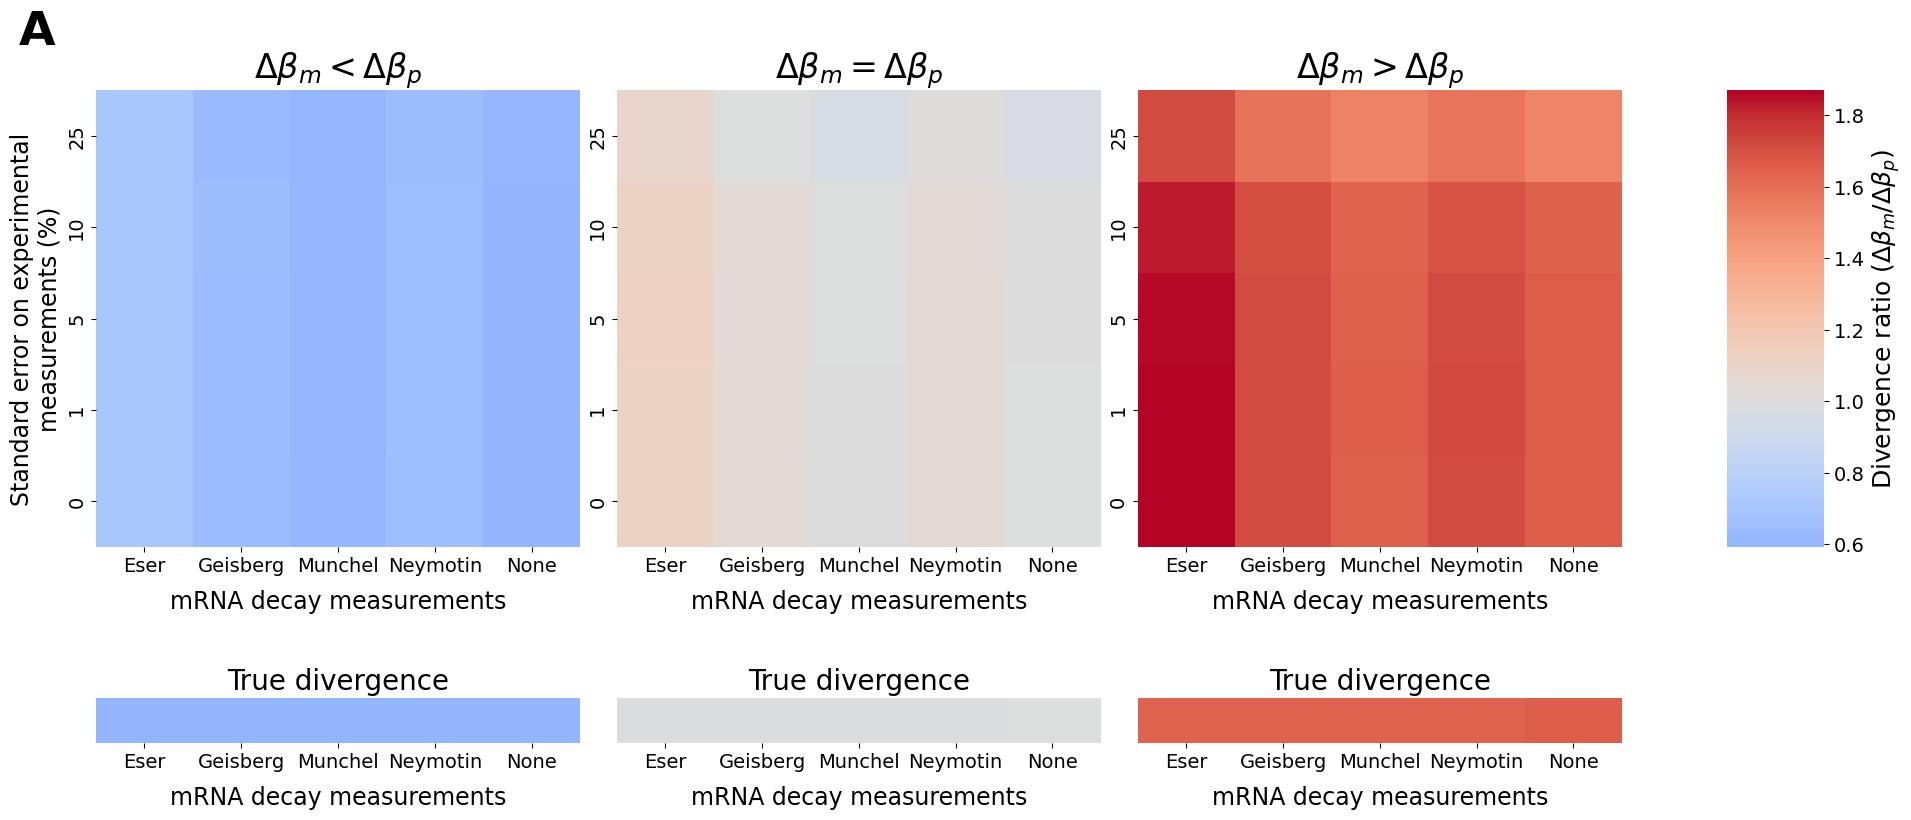

In [ ]:
# First part: variance as in our estimates
fig = plt.figure(constrained_layout=True, figsize=(19, 9))

# Preparation of the grids and axes
gs0 = fig.add_gridspec(14, 17)


# Axes for heatmaps
ax0 = fig.add_subplot(gs0[0:10, 0:5])
ax1 = fig.add_subplot(gs0[0:10, 5:10])
ax2 = fig.add_subplot(gs0[0:10, 10:15])

# Axe for colorbar
ax3 = fig.add_subplot(gs0[0:10, 16])

# Axes for true ratios
ax4 = fig.add_subplot(gs0[11:12, 0:5])
ax5 = fig.add_subplot(gs0[11:12, 5:10])
ax6 = fig.add_subplot(gs0[11:12, 10:15])

# Heatmaps of apparent ratios
measured_1 = sns.heatmap(mat_Bp_app, vmin=min_div, vmax=max_div,
                         ax=ax0, center=1.0, cmap='coolwarm',
                         cbar=False)
measured_2 = sns.heatmap(mat_equal_app, vmin=min_div, vmax=max_div,
                         ax=ax1, center=1.0, cmap='coolwarm',
                         cbar=False)
measured_3 = sns.heatmap(mat_Bm_app, vmin=min_div, vmax=max_div,
                         ax=ax2, center=1.0, cmap='coolwarm',
                         cbar_ax=ax3)

# True ratios
true_1 = sns.heatmap(mat_Bp_true, vmin=min_div, vmax=max_div,
                     ax=ax4, center=1.0, cmap='coolwarm',
                     cbar=False)
true_2 = sns.heatmap(mat_equal_true, vmin=min_div, vmax=max_div,
                     ax=ax5, center=1.0, cmap='coolwarm',
                     cbar=False)
true_3 = sns.heatmap(mat_Bm_true, vmin=min_div, vmax=max_div,
                    ax=ax6, center=1.0, cmap='coolwarm',
                     cbar=False)

# Adjusting axis and color bars ticks and labels
for ax in [ax0, ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.set_xlabel('mRNA decay measurements', fontsize=17, labelpad=10)
  ax.set_ylabel('')

for ax in [ax4, ax5, ax6]:
  ax.tick_params(axis='x', which='major', labelsize=14)
  ax.tick_params(axis='y', which='both', left=False, labelleft=False)
  ax.set_xlabel('mRNA decay measurements', fontsize=17, labelpad=10)
  ax.set_ylabel('')

ax0.set_ylabel('Standard error on experimental\nmeasurements (%)', fontsize=17)

ax3.tick_params(labelsize=14)
ax3.set_ylabel(r"Divergence ratio ($\Delta\beta_m$/$\Delta\beta_p$)",
               fontsize=18)

# Adding titles
ax0.set_title(r"$\Delta\beta_m < \Delta\beta_p$", fontsize=24)
ax1.set_title(r"$\Delta\beta_m = \Delta\beta_p$", fontsize=24)
ax2.set_title(r"$\Delta\beta_m > \Delta\beta_p$", fontsize=24)

ax4.set_title('True divergence', fontsize=20)
ax5.set_title('True divergence', fontsize=20)
ax6.set_title('True divergence', fontsize=20)

# Adding subfigure annotation
ax0.annotate('A', (-0.16, 1.1), xycoords='axes fraction',
                             fontsize=34, fontweight="bold")

FigS3 = plt.gcf()
#FigS3.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS3_emp.pdf', bbox_inches='tight')
FigS3.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS3_emp.tiff', bbox_inches='tight')

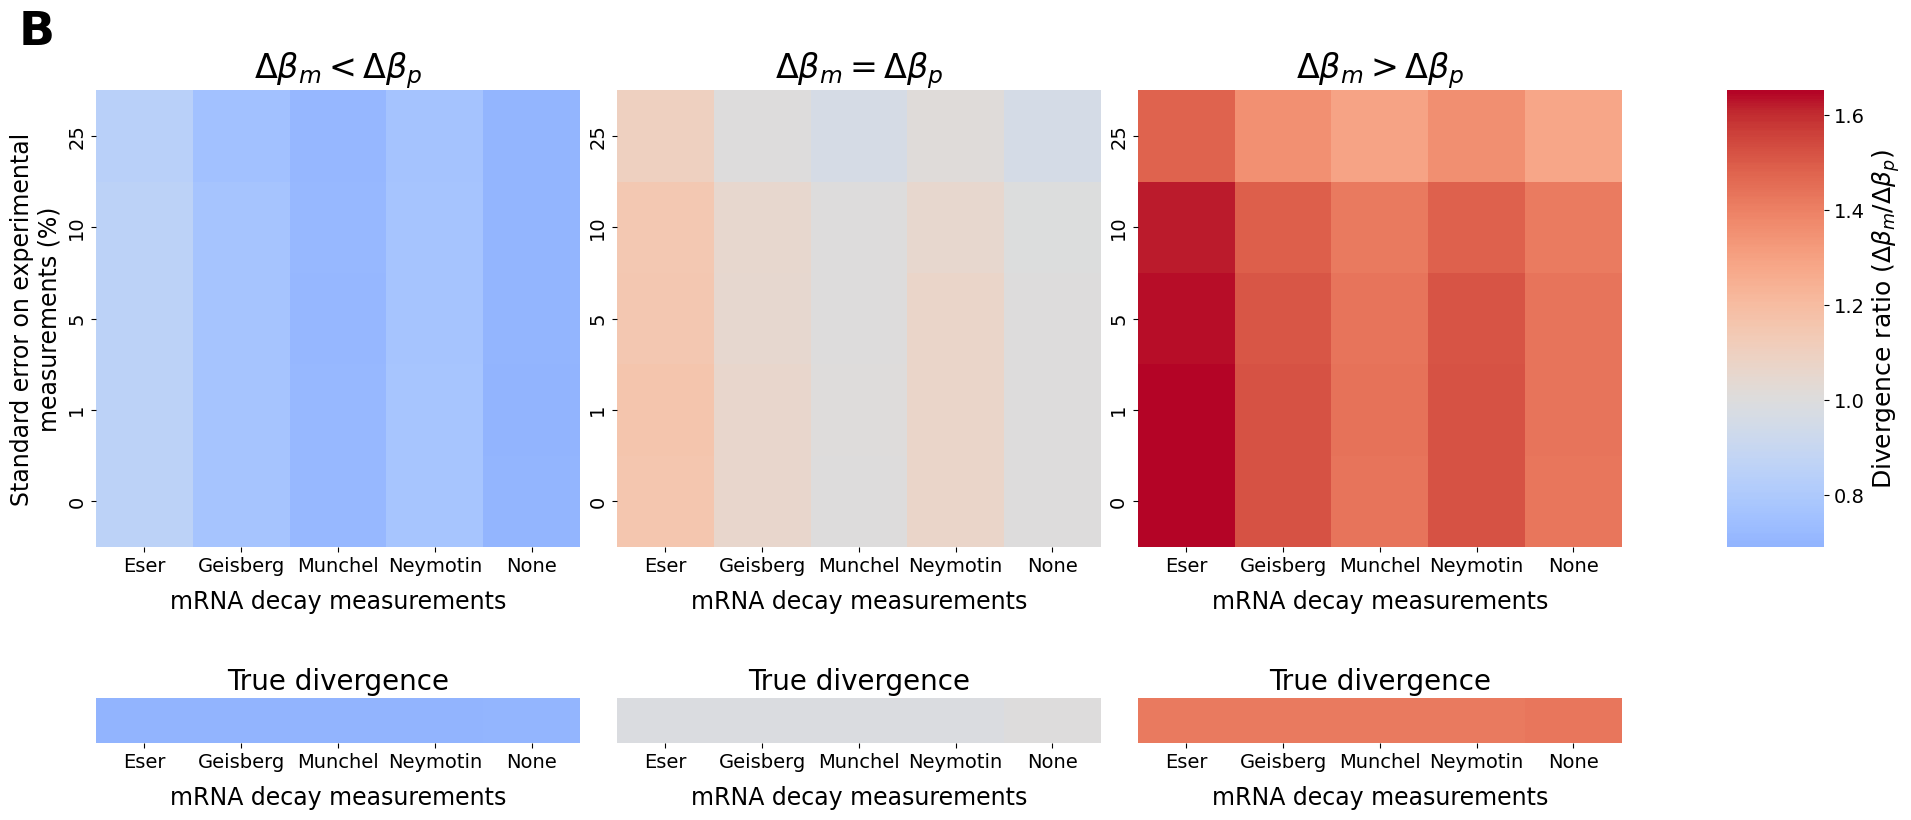

In [ ]:
# Second part: Half of the variance in our relative divergence estimates
fig = plt.figure(constrained_layout=True, figsize=(19, 9))

# Preparation of the grids and axes
gs0 = fig.add_gridspec(14, 17)


# Axes for heatmaps
ax0 = fig.add_subplot(gs0[0:10, 0:5])
ax1 = fig.add_subplot(gs0[0:10, 5:10])
ax2 = fig.add_subplot(gs0[0:10, 10:15])

# Axe for colorbar
ax3 = fig.add_subplot(gs0[0:10, 16])

# Axes for true ratios
ax4 = fig.add_subplot(gs0[11:12, 0:5])
ax5 = fig.add_subplot(gs0[11:12, 5:10])
ax6 = fig.add_subplot(gs0[11:12, 10:15])

# Heatmaps of apparent ratios
measured_1 = sns.heatmap(mat_Bp_app_half, vmin=min_div_half, vmax=max_div_half,
                         ax=ax0, center=1.0, cmap='coolwarm',
                         cbar=False)
measured_2 = sns.heatmap(mat_equal_app_half, vmin=min_div_half, vmax=max_div_half,
                         ax=ax1, center=1.0, cmap='coolwarm',
                         cbar=False)
measured_3 = sns.heatmap(mat_Bm_app_half, vmin=min_div_half, vmax=max_div_half,
                         ax=ax2, center=1.0, cmap='coolwarm',
                         cbar_ax=ax3)

# True ratios
true_1 = sns.heatmap(mat_Bp_true_half, vmin=min_div_half, vmax=max_div_half,
                     ax=ax4, center=1.0, cmap='coolwarm',
                     cbar=False)
true_2 = sns.heatmap(mat_equal_true_half, vmin=min_div_half, vmax=max_div_half,
                     ax=ax5, center=1.0, cmap='coolwarm',
                     cbar=False)
true_3 = sns.heatmap(mat_Bm_true_half, vmin=min_div_half, vmax=max_div_half,
                    ax=ax6, center=1.0, cmap='coolwarm',
                     cbar=False)

# Adjusting axis and color bars ticks and labels
for ax in [ax0, ax1, ax2]:
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.set_xlabel('mRNA decay measurements', fontsize=17, labelpad=10)
  ax.set_ylabel('')

for ax in [ax4, ax5, ax6]:
  ax.tick_params(axis='x', which='major', labelsize=14)
  ax.tick_params(axis='y', which='both', left=False, labelleft=False)
  ax.set_xlabel('mRNA decay measurements', fontsize=17, labelpad=10)
  ax.set_ylabel('')

ax0.set_ylabel('Standard error on experimental\nmeasurements (%)', fontsize=17)

ax3.tick_params(labelsize=14)
ax3.set_ylabel(r"Divergence ratio ($\Delta\beta_m$/$\Delta\beta_p$)",
               fontsize=18)

# Adding titles
ax0.set_title(r"$\Delta\beta_m < \Delta\beta_p$", fontsize=24)
ax1.set_title(r"$\Delta\beta_m = \Delta\beta_p$", fontsize=24)
ax2.set_title(r"$\Delta\beta_m > \Delta\beta_p$", fontsize=24)

ax4.set_title('True divergence', fontsize=20)
ax5.set_title('True divergence', fontsize=20)
ax6.set_title('True divergence', fontsize=20)

# Adding subfigure annotation
ax0.annotate('B', (-0.16, 1.1), xycoords='axes fraction',
                             fontsize=34, fontweight="bold")

FigS3 = plt.gcf()
#FigS3.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS3_half.pdf', bbox_inches='tight')
FigS3.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS3_half.tiff', bbox_inches='tight')

## Construction of Figure S4

### Generation of the mock data

First in the case where m (mRNA abundance) and wRPF (abundance of ribosome-protected fragments) are independent:

In [ ]:
# Redefining the fold-change so that it does not assume log10 values, as
# it will be more convenient here
def fold_change_lin(prop_P1, prop_P2, data, name):
  """Function to calculate log2 fold-change for a property between two
     duplicates. The two properties are provided as dataframe columns.
     The last argument is used to specify the name of the new column 
     inserted in the data dataframe."""

  df = data.copy()
  df[name] = np.NaN

  for row in range(df.shape[0]):

    value_P1 = df.at[row, f'{prop_P1}']
    value_P2 = df.at[row, f'{prop_P2}']

    if value_P1 >= value_P2:

      df.at[row, name] = (value_P1)/(value_P2)

    elif value_P1 < value_P2:

      df.at[row, name] = (value_P2)/(value_P1)

  df[name] = np.log2(df[name])

  return df


In [ ]:
rng = np.random.default_rng()

# Random m for P1 and P2
m = rng.normal(loc=100, scale=15, size=(10000, 2))

# Random wRPF for P1 and P2
wRPF = rng.normal(loc=100, scale=15, size=(10000, 2))

# Computing pseudo translation rates
pseudo_Bp = wRPF/m

# Computing log2 fold-changes
pseudo_fold = pd.DataFrame(columns=['m_P1', 'm_P2', 'Bp_P1', 'Bp_P2', 'm_fold',
                                    'Bp_fold', 'm_signed_1', 'm_signed_2',
                                    'Bp_signed_1', 'Bp_signed_2'])

pseudo_fold['m_P1'] = m[:, 0]
pseudo_fold['m_P2'] = m[:, 1]
pseudo_fold['Bp_P1'] = pseudo_Bp[:, 0]
pseudo_fold['Bp_P2'] = pseudo_Bp[:, 1]
pseudo_fold['m_fold'] = fold_change_lin('m_P1', 'm_P2', pseudo_fold, 'm_fold')['m_fold']
pseudo_fold['Bp_fold'] = fold_change_lin('Bp_P1', 'Bp_P2', pseudo_fold, 'Bp_fold')['Bp_fold']
pseudo_fold['m_signed_1'] = np.log2(pseudo_fold['m_P1'] / pseudo_fold['m_P2'])
pseudo_fold['m_signed_2'] = np.log2(pseudo_fold['m_P2'] / pseudo_fold['m_P1'])
pseudo_fold['Bp_signed_1'] = np.log2(pseudo_fold['Bp_P1'] / pseudo_fold['Bp_P2'])
pseudo_fold['Bp_signed_2'] = np.log2(pseudo_fold['Bp_P2'] / pseudo_fold['Bp_P1'])

Second, in the case where m and wRPF are almost perfectly correlated (as seen in the original data):

In [ ]:
# Covariance matrix
cov = 0.98 * math.sqrt(15**2 * 15**2)
cov_mat = np.array([[15**2, cov], [cov, 15**2]])

# Sampling of pairs of values
bivar_P1 = rng.multivariate_normal((100,100), cov_mat, 10000) 
bivar_P2 = rng.multivariate_normal((100,100), cov_mat, 10000)

# Compiling data and computing log2 as well as signed fold-changes
pseudo_corr = pd.DataFrame(columns=['m_P1', 'm_P2', 'wRPF_P1', 'wRPF_P2', 
                                    'Bp_P1', 'Bp_P2', 'm_fold', 'Bp_fold',
                                    'm_signed_1', 'm_signed_2', 'Bp_signed_1',
                                    'Bp_signed_2'])

pseudo_corr['m_P1'] = bivar_P1[:, 0]
pseudo_corr['m_P2'] = bivar_P2[:, 0]
pseudo_corr['wRPF_P1'] = bivar_P1[:, 1]
pseudo_corr['wRPF_P2'] = bivar_P2[:, 1]
pseudo_corr['Bp_P1'] = pseudo_corr['wRPF_P1'] / pseudo_corr['m_P1']
pseudo_corr['Bp_P2'] = pseudo_corr['wRPF_P2'] / pseudo_corr['m_P2']
pseudo_corr['m_fold'] = fold_change_lin('m_P1', 'm_P2', pseudo_corr, 'm_fold')['m_fold']
pseudo_corr['Bp_fold'] = fold_change_lin('Bp_P1', 'Bp_P2', pseudo_corr, 'Bp_fold')['Bp_fold']
pseudo_corr['m_signed_1'] = np.log2(pseudo_corr['m_P1'] / pseudo_corr['m_P2'])
pseudo_corr['m_signed_2'] = np.log2(pseudo_corr['m_P2'] / pseudo_corr['m_P1'])
pseudo_corr['Bp_signed_1'] = np.log2(pseudo_corr['Bp_P1'] / pseudo_corr['Bp_P2'])
pseudo_corr['Bp_signed_2'] = np.log2(pseudo_corr['Bp_P2'] / pseudo_corr['Bp_P1'])

### Constructing the figure

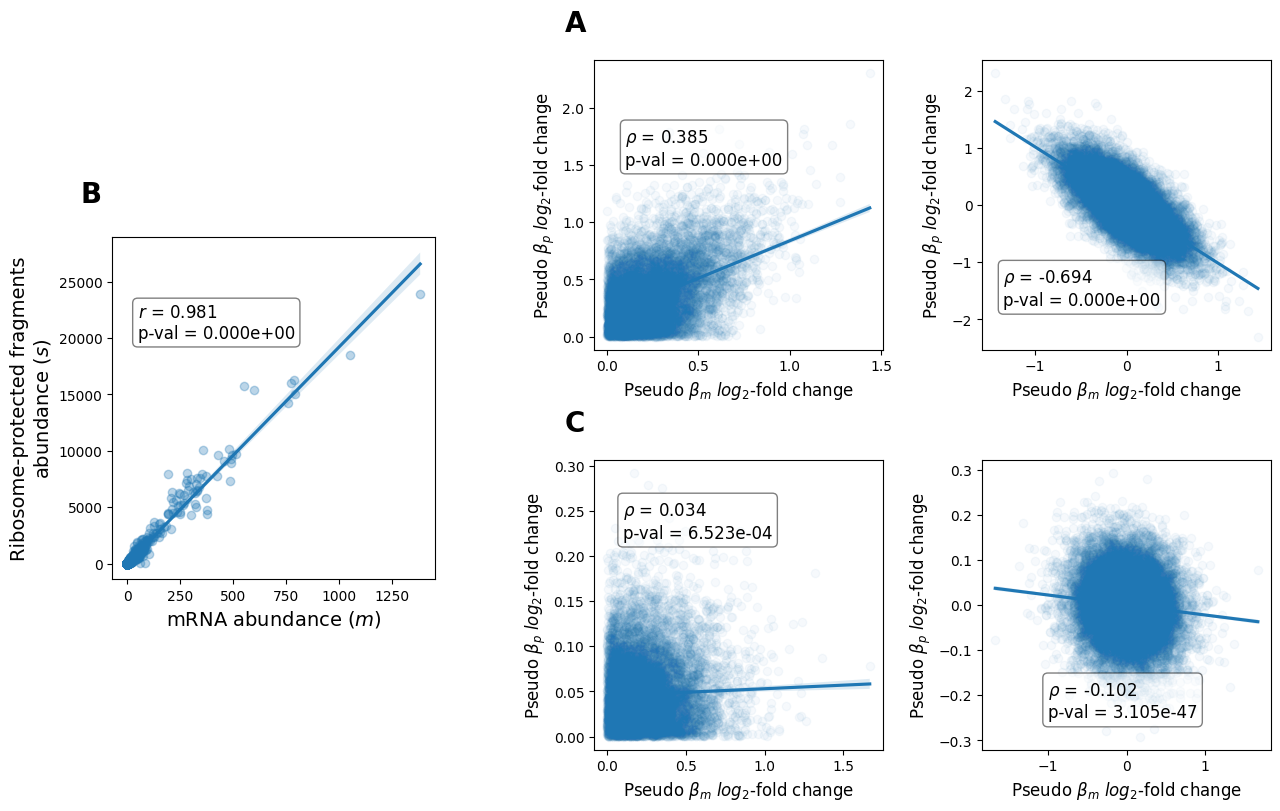

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(17, 8))

# Preparation of the grids and axes
gs0 = fig.add_gridspec(1, 9)

gs00 = gs0[0:4].subgridspec(8, 8)
gs01 = gs0[4:8].subgridspec(2, 2)

ax0 = fig.add_subplot(gs00[2:6, 3:7])

# Dictionary of axes for thr right part
axes_dict = {}

for a in range(2):
    for b in range(2):
        ax = fig.add_subplot(gs01[a, b])
        axes_dict[f'({a}, {b})'] = ax

# Plotting

# Panel B: Observed correlation between m and wRPF
rates_lin = genes_decay[['m', 'wRPF']].copy()
rates_lin = 10**rates_lin

sns.regplot(x='m', y='wRPF', data=rates_lin, ax=ax0, 
            scatter_kws={'alpha':0.3}, robust=True)

pearson_rates = stats.pearsonr(rates_lin['m'], rates_lin['wRPF'])

ax0.annotate(r"$r$ = "f'{round(pearson_rates[0], 3)}\np-val = {pearson_rates[1]:.3e}',
             (50, 20000), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
             fontsize=12)
ax0.set_xlabel(r"mRNA abundance ($m$)", fontsize=14)
ax0.set_ylabel(r"Ribosome-protected fragments"'\n'r"abundance ($s$)", fontsize=14)
ax0.annotate('B', (-0.1, 1.1), xycoords='axes fraction',
             fontsize=20, fontweight="bold")

# Panel A: Expected correlations for independent variables
fold_ind = sns.regplot(x='m_fold', y='Bp_fold', data=pseudo_fold, 
                       ax=axes_dict['(0, 0)'], scatter_kws={'alpha':0.04},
                       robust=True)

spearman_pseudo = stats.spearmanr(pseudo_fold['m_fold'], pseudo_fold['Bp_fold'])

axes_dict['(0, 0)'].annotate(r"$\rho$ = "f'{round(spearman_pseudo[0], 3)}\np-val = {spearman_pseudo[1]:.3e}',
                             (0.1, 1.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

axes_dict['(0, 0)'].set_xlabel(r"Pseudo $\beta_m$ $log_{2}$-fold change", fontsize=12)
#axes_dict['(0, 0)'].set_xlabel(r"$m$ $log_{2}$-fold change", fontsize=12)
axes_dict['(0, 0)'].set_ylabel(r"Pseudo $\beta_p$ $log_{2}$-fold change", fontsize=12)
#axes_dict['(0, 0)'].set_ylabel(r"$\frac{s}{m}$ $log_{2}$-fold change", fontsize=12)

axes_dict['(0, 0)'].annotate('A', (-0.1, 1.1), xycoords='axes fraction',
                             fontsize=20, fontweight="bold")

signed_pseudo = pd.DataFrame(columns=['m_signed', 'Bp_signed'])
signed_pseudo['m_signed'] = np.concatenate([pseudo_fold['m_signed_1'],
                                            pseudo_fold['m_signed_2']])
signed_pseudo['Bp_signed'] = np.concatenate([pseudo_fold['Bp_signed_1'],
                                            pseudo_fold['Bp_signed_2']])
signed_ind = sns.regplot(x='m_signed', y='Bp_signed', data=signed_pseudo,
                         ax=axes_dict['(0, 1)'], scatter_kws={'alpha':0.04},
                         robust=True)

spearman_signed = stats.spearmanr(signed_pseudo['m_signed'], 
                                  signed_pseudo['Bp_signed'])
axes_dict['(0, 1)'].annotate(r"$\rho$ = "f'{round(spearman_signed[0], 3)}\np-val = {spearman_signed[1]:.3e}',
                             (-1.35, -1.75), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)

axes_dict['(0, 1)'].set_xlabel(r"Pseudo $\beta_m$ $log_{2}$-fold change", fontsize=12)
#axes_dict['(0, 1)'].set_xlabel(r"$m$ signed $log_{2}$-fold change", fontsize=12)
#axes_dict['(0, 1)'].set_ylabel(r"$\frac{s}{m}$ signed $log_{2}$-fold change", 
                               #fontsize=12)
axes_dict['(0, 1)'].set_ylabel(r"Pseudo $\beta_p$ $log_{2}$-fold change", fontsize=12)


# Panel C: Expected correlations for realistically correlated m and wRPF
fold_corr = sns.regplot(x='m_fold', y='Bp_fold', data=pseudo_corr, 
                       ax=axes_dict['(1, 0)'], scatter_kws={'alpha':0.04},
                       robust=True)

spearman_pseudo = stats.spearmanr(pseudo_corr['m_fold'], pseudo_corr['Bp_fold'])

axes_dict['(1, 0)'].annotate(r"$\rho$ = "f'{round(spearman_pseudo[0], 3)}\np-val = {spearman_pseudo[1]:.3e}',
                             (0.1, 0.22), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=12)

#axes_dict['(1, 0)'].set_xlabel(r"$m$ $log_{2}$-fold change", fontsize=12)
#axes_dict['(1, 0)'].set_ylabel(r"$\frac{s}{m}$ $log_{2}$-fold change", fontsize=12)
axes_dict['(1, 0)'].set_xlabel(r"Pseudo $\beta_m$ $log_{2}$-fold change", fontsize=12)
axes_dict['(1, 0)'].set_ylabel(r"Pseudo $\beta_p$ $log_{2}$-fold change", fontsize=12)

#axes_dict['(1, 0)'].annotate('Expected for independent measurements', 
                             #(0.15, 1.025), xycoords='axes fraction',
                             #fontsize=16, fontweight="bold")

axes_dict['(1, 0)'].annotate('C', (-0.1, 1.1), xycoords='axes fraction',
                             fontsize=20, fontweight="bold")

signed_pseudo = pd.DataFrame(columns=['m_signed', 'Bp_signed'])
signed_pseudo['m_signed'] = np.concatenate([pseudo_corr['m_signed_1'],
                                            pseudo_corr['m_signed_2']])
signed_pseudo['Bp_signed'] = np.concatenate([pseudo_corr['Bp_signed_1'],
                                            pseudo_corr['Bp_signed_2']])
signed_corr = sns.regplot(x='m_signed', y='Bp_signed', data=signed_pseudo,
                          ax=axes_dict['(1, 1)'], scatter_kws={'alpha':0.04},
                          robust=True)

spearman_signed = stats.spearmanr(signed_pseudo['m_signed'], 
                                  signed_pseudo['Bp_signed'])
axes_dict['(1, 1)'].annotate(r"$\rho$ = "f'{round(spearman_signed[0], 3)}\np-val = {spearman_signed[1]:.3e}',
                             (-1.0, -0.25), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                             fontsize=12)
#axes_dict['(1, 1)'].annotate('Expected for correlated measurements', 
                             #(0.15, 1.025), xycoords='axes fraction',
                             #fontsize=16, fontweight="bold")

#axes_dict['(1, 1)'].set_xlabel(r"$m$ signed $log_{2}$-fold change", fontsize=12)
#axes_dict['(1, 1)'].set_ylabel(r"$\frac{s}{m}$ signed $log_{2}$-fold change", fontsize=12)
axes_dict['(1, 1)'].set_xlabel(r"Pseudo $\beta_m$ $log_{2}$-fold change", fontsize=12)
axes_dict['(1, 1)'].set_ylabel(r"Pseudo $\beta_p$ $log_{2}$-fold change", fontsize=12)

FigS4 = plt.gcf()
#FigS4.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS4.pdf', bbox_inches='tight')
FigS4.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS4.tiff', bbox_inches='tight')